## Question 1


In [3]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.metrics import roc_curve, auc
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker

In [6]:
import pandas as pd
# Read in data and assign X and y   %%% Dois je 
# utiliser ceux de la question 3 o u 4
data = pd.read_csv('../data/Milestone2_data/Q4_train.csv', index_col=0)
print(data.columns)
X = data[['distance', 'angle' ]]
print(X)
# Classification binaire utilisant isGoal comme cible
y = data[['isGoal']]

print(y)


Index(['period', 'shotType', 'coordinateX', 'coordinateY', 'emptynet',
       'lastEvent', 'lastCoordinateX', 'lastCoordinateY', 'lastDistance',
       'timeLastEvent', 'speed', 'rebound', 'distance', 'angle', 'gameSeconds',
       'chang_angle', 'non_gardiens_amicaux', 'non_gardiens_adverses',
       'isGoal'],
      dtype='object')
              distance    angle
gameId                         
2016020001   13.000000  22.6199
2016020001   13.341664  77.0054
2016020001  118.270876 -18.7413
2016020001   57.974132 -14.9951
2016020001   61.717096  26.9802
...                ...      ...
2019030416   38.418745 -38.6598
2019030416    8.544004  20.5560
2019030416   55.326305  -6.2258
2019030416   58.855756   9.7824
2019030416   12.000000   0.0000

[327295 rows x 2 columns]
            isGoal
gameId            
2016020001       0
2016020001       0
2016020001       0
2016020001       0
2016020001       0
...            ...
2019030416       0
2019030416       0
2019030416       0
2019030416  

In [27]:


print(data.tail())

            period  shotType  coordinateX  coordinateY  emptynet  lastEvent  \
gameId                                                                        
2019030416       3         3        -59.0        -24.0         0          4   
2019030416       3         6        -81.0          3.0         0          0   
2019030416       3         3         34.0         -6.0         0         13   
2019030416       3         6         31.0         10.0         0          2   
2019030416       3         6         77.0          0.0         0          7   

            lastCoordinateX  lastCoordinateY  lastDistance  timeLastEvent  \
gameId                                                                      
2019030416               64              -26    123.016259          86397   
2019030416              -80                6      3.162278          86398   
2019030416               92              -16     58.855756          86392   
2019030416               69              -22     49.678969   

In [57]:
def XGB(X, y, liste_caracteristiques):
    '''
    Arguments :
    X = pd.DataFrame X
    y = étiquettes cibles
    liste_caracteristiques = liste des caractéristiques
    '''
    # Affiche les caractéristiques sélectionnées dans X
    X_train, X_val, y_train, y_val = train_test_split(X[liste_caracteristiques], y, test_size=0.2, random_state=42)

    # Modèle XGB
    clf = xgb.XGBClassifier()
    
    y_train = y_train.values.ravel()
    clf.fit(X_train, y_train)
    
    # Prédiction sur l'ensemble de validation
    y_pred = clf.predict(X_val)
    precision = metrics.accuracy_score(y_val, y_pred)
    
    # Probabilités de prédiction
    pred_probs = clf.predict_proba(X_val)
    
    
    
    #Metrics d'.valuation du modele
    accuracy = metrics.accuracy_score(y_val, y_pred)
    f1_score = metrics.f1_score(y_val, y_pred)
    precision = metrics.precision_score(y_val, y_pred)
    recall = metrics.recall_score(y_val, y_pred)
    cf_matrix = metrics.confusion_matrix(y_val,y_pred)
    
    probs_isgoal = pred_probs[:,1]
    roc_auc = metrics.roc_auc_score(y_val,probs_isgoal)
    
    return X_val, y_val, y_pred, precision,accuracy, f1_score, recall, roc_auc, pred_probs # Retourner les métriques et résultats

In [7]:
import matplotlib.pyplot as plt
def tracer_roc_deux_chars(X, y):

    fig = plt.figure(figsize=(12,10))
    
    liste_caracteristiques = (['distance'], ['angle'], ['distance', 'angle']  )
    liste_couleurs = ['orange', 'violet', 'blue']
    liste_labels = ['Distance du Filet', 'Angle du Filet', 'Distance et Angle du Filet']

    
    for i, caracteristique in enumerate(liste_caracteristiques):
        X_val, y_val, y_pred, precision,accuracy, f1_score, recall, roc_auc, pred_probs = XGB(X, y, caracteristique)           
        print(f' accuracy: {accuracy}')
        print(f' f1_score: {f1_score}')
        print(f' precision: {precision}')
        print(f' recall: {recall}')
        print(f' roc_auc: {roc_auc}')
            
        couleur_trace = liste_couleurs[i]
        label_trace = liste_labels[i]
            
        probs_isgoal = pred_probs[:,1]
        fpr, tpr, _ = roc_curve(y_val, probs_isgoal)
        
        roc_auc = auc(fpr, tpr)
        
    
        plt.plot(fpr, tpr, color=couleur_trace, label=f'{label_trace} '+'AUC = %0.2f' % roc_auc, lw=2) 
        
    # Baseline Aléatoire
    baseline_is_goal = np.random.uniform(0, 1, probs_isgoal.shape[0])
    couleur_trace = 'red'
    label_trace = 'Baseline Aléatoire'
    fpr, tpr, _ = roc_curve(y_val, baseline_is_goal)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=couleur_trace, label=f'{label_trace} '+'AUC = %0.2f' % roc_auc, lw=2)
            
    ax = plt.gca()
    ax.grid()
    ax.set_facecolor('0.95')
    
    plt.title('Courbes ROC', fontsize=20)
    plt.legend(loc=2, prop={'size': 16})
    plt.rc('xtick', labelsize=16)
    plt.rc('ytick', labelsize=16)
    plt.ylabel('Taux de Vrais Positifs', fontsize=20)
    plt.xlabel('Taux de Faux Positifs', fontsize=20)    
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'../figures/Milestone_2/2-5-1a_Courbes_ROC.png')
    plt.show()

In [8]:
tracer_roc_deux_chars(X, y)

NameError: name 'XGB' is not defined

<Figure size 1200x1000 with 0 Axes>

In [9]:
print(data.columns)

Index(['period', 'shotType', 'coordinateX', 'coordinateY', 'emptynet',
       'lastEvent', 'lastCoordinateX', 'lastCoordinateY', 'lastDistance',
       'timeLastEvent', 'speed', 'rebound', 'distance', 'angle', 'gameSeconds',
       'chang_angle', 'non_gardiens_amicaux', 'non_gardiens_adverses',
       'isGoal'],
      dtype='object')


In [10]:
data = pd.read_csv('Q4_train.csv', index_col=0)
X = data[['distance', 'angle' ]]
# Classification binaire utilisant isGoal comme cible
y = data[['isGoal']]


FileNotFoundError: [Errno 2] No such file or directory: 'Q4_train.csv'

In [45]:
def calc_percentile(pred_probs, y_val):
    
    # Créer un DataFrame pour les probabilités de tir
    df_probs = pd.DataFrame(pred_probs)
    df_probs = df_probs.rename(columns={0: "Probabilité_Non_But", 1: "Probabilité_But"})
    
    # Combiner la 'Probabilité de But' et 'Est But' dans un seul DataFrame
    df_probs = pd.concat([df_probs["Probabilité_But"].reset_index(drop=True), y_val["isGoal"].reset_index(drop=True)], axis=1)
    
    # Calculer et ajouter la colonne de Percentile
    valeurs_percentile = df_probs['Probabilité_But'].rank(pct=True)
    df_probs['Percentile'] = valeurs_percentile * 100
    df_percentile = df_probs.copy()
    
    return df_percentile

In [49]:
def taux_but(df_percentile):
   
    liste_taux = []
    
    # Trouver le nombre total de buts
    total_buts = df_percentile['isGoal'].value_counts()[1]
  
   
    largeur_bin = 5

    i = 0
    liste_i = []
    
    while i < (100 - largeur_bin + 1):  # 95 est la limite inférieure du dernier intervalle
        liste_i.append(i)

        # Taille de l'intervalle i
        borne_inferieure = i
        borne_superieure = i + largeur_bin

        # Trouver les lignes dont les percentiles sont dans cette plage
        lignes_intervalle = df_percentile[(df_percentile['Percentile'] >= borne_inferieure) & (df_percentile['Percentile'] < borne_superieure)]
        
        # Calculer le taux de but à partir du nombre total de buts et de tirs dans chaque lignes_intervalle
        # buts = lignes_intervalle['isGoal'].value_counts()[1].get(1, 0)   
        buts = lignes_intervalle['isGoal'].value_counts().get(1, 0)   
        tirs = len(lignes_intervalle)  # nombre total de tirs dans lignes_intervalle
        taux = (buts / tirs) * 100  # taux de but en pourcentage

        liste_taux.append(taux)

        i += largeur_bin
    
    # Créer un nouveau DataFrame en combinant la liste des taux de buts et la liste des percentiles
    df_taux_but = pd.DataFrame(list(zip(liste_taux, liste_i)), columns=['Taux', 'Percentile'])
    
    return df_taux_but

In [48]:


def taux_but(df_percentile):
    liste_taux = []
    
    # Supprime les lignes contenant des NaN dans les colonnes pertinentes
    df_percentile = df_percentile.dropna(subset=['isGoal', 'Percentile'])

    largeur_bin = 5  # Taille de chaque intervalle de percentile
    i = 0
    liste_percentiles = []
    
    while i < (100 - largeur_bin + 1):  # 95 est la limite inférieure du dernier bin
        liste_percentiles.append(i)

        # Taille du i-ème bin
        borne_inferieure = i
        borne_superieure = i + largeur_bin

        # Filtrer les lignes dont les percentiles sont dans cet intervalle
        lignes_intervalle = df_percentile[
            (df_percentile['Percentile'] >= borne_inferieure) &
            (df_percentile['Percentile'] < borne_superieure)
        ]
        
        # Calculer le taux de but à partir du nombre total de buts et de tirs dans chaque lignes_intervalle
        buts = lignes_intervalle['isGoal'].value_counts().get(1, 0)      
        tirs = len(lignes_intervalle)  # nombre total de tirs dans lignes_intervalle
        taux = (buts / tirs) * 100 if tirs > 0 else 0  # taux de but en pourcentage, évite la division par zéro

        liste_taux.append(taux)
        i += largeur_bin
    
    # Créer un DataFrame combinant la liste des taux de but et des percentiles
    df_taux_but = pd.DataFrame(list(zip(liste_taux, liste_percentiles)), columns=['Taux', 'Percentile'])
    
    return df_taux_but



In [50]:
def tracer_taux_de_but_deux_chars(X, y):

    fig = plt.figure(figsize=(12,10))
    
    liste_caracteristiques = (['distance'], ['angle'], ['distance', 'angle'])
    liste_couleurs_caracteristiques = ['red', 'green', 'cyan']
    liste_labels_plot = ['Distance par rapport au but', 'Angle par rapport au but', 'Distance et angle par rapport au but']
    
    # Boucle pour chaque ensemble de caractéristiques
    for i, caracteristique in enumerate(liste_caracteristiques):
        
        
        # Exécuter le modèle avec les caractéristiques sélectionnées
        X_val, y_val, y_pred, precision, pred_probs = XGB(X, y, caracteristique)
        print(f'Score de précision : {precision}')
        
        couleur_plot = liste_couleurs_caracteristiques[i]
        label_plot = liste_labels_plot[i]
        
        # Calculer les percentiles et le taux de but
        df_percentile = calc_percentile(pred_probs, y_val)
        print(df_percentile['isGoal'].unique())
        df_taux_but = taux_but(df_percentile)
        x_taux_but = df_taux_but['Percentile']
        y_taux_but = df_taux_but['Taux']
        
        # Tracer le taux de but en fonction du percentile
        plt.plot(x_taux_but, y_taux_but, color=couleur_plot, label=f'{label_plot}')
        
    # Baseline aléatoire
    probs_est_but = pred_probs[:,1]
    baseline_est_but = np.random.uniform(0, 1, probs_est_but.shape[0])
    pas_but_baseline = np.array([(1 - i) for i in baseline_est_but])
    probs_aleatoires = np.column_stack((baseline_est_but, pas_but_baseline))
    df_percentile = calc_percentile(probs_aleatoires, y_val)
    
    df_taux_but = taux_but(df_percentile)
    x_taux_but = df_taux_but['Percentile']
    y_taux_but = df_taux_but['Taux']
    
    couleur_plot = 'black'
    label_plot = 'Baseline aléatoire'
    plt.plot(x_taux_but, y_taux_but, color=couleur_plot, label=f'{label_plot}')
    
    # Configurations du graphique
    ax = plt.gca()
    ax.grid()
    ax.set_facecolor('0.95')
    
    ax.set_ylim([0, 100])
    ax.set_xlim([0, 100])
    ax.invert_xaxis()
    major_ticks = np.arange(0, 110, 10)
    ax.set_xticks(major_ticks)
    ax.set_yticks(major_ticks)
    
    plt.rc('xtick', labelsize=16)
    plt.rc('ytick', labelsize=16)
    
    plt.grid(True)
    plt.title('Taux de But', fontsize=20)
    plt.xlabel('Percentile du modèle de probabilité de tir', fontsize=16)
    plt.ylabel('Buts / (Tirs + Buts)%', fontsize=16)
    plt.legend(loc=2, prop={'size': 16})
    plt.tight_layout()
    plt.savefig(f'2-5-1b_taux_de_buts.png')
    plt.show()

In [102]:
print(data['isGoal'].unique())

[0 1]


In [133]:
print(y)  # Pour voir si 'isGoal' est bien une colonne de y


        isGoal
0            0
1            0
2            0
3            0
4            1
...        ...
189471       0
189472       0
189473       0
189474       0
189475       0

[189476 rows x 1 columns]


Score de précision : 0.9050856261171115
[0 1]
Score de précision : 0.9050856261171115
[0 1]
Score de précision : 0.9050856261171115
[0 1]


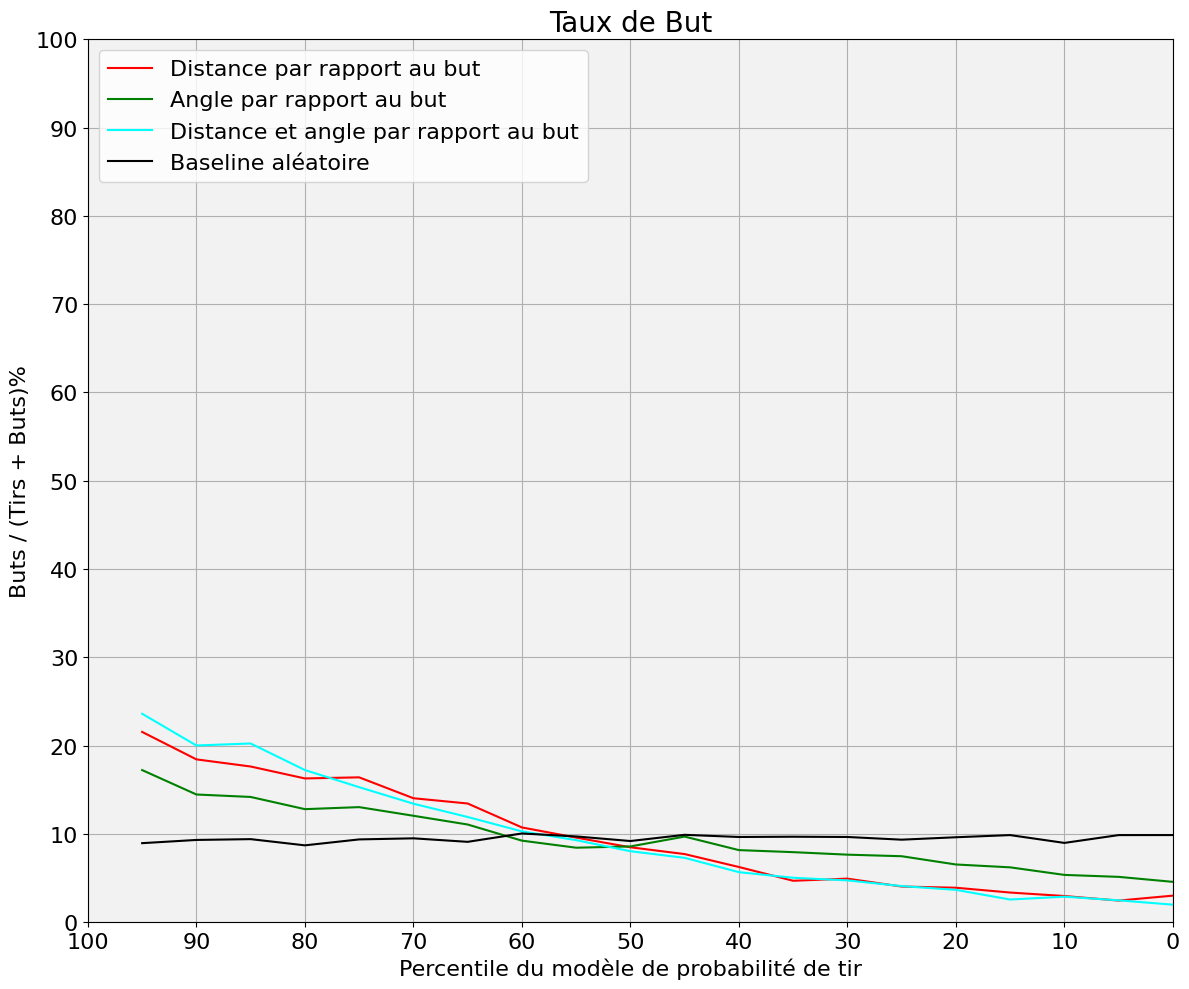

In [51]:
tracer_taux_de_but_deux_chars(X, y)

In [11]:
def tracer_taux_cumulatif_deux_caracs(X, y):

    fig = plt.figure(figsize=(12,10))
    
    liste_caracteristiques = (['distance'], ['angle'], ['distance', 'angle'])
    liste_couleurs = ['orange', 'violet', 'cyan']
    liste_etiquettes = ['Distance du filet', 'Angle du filet', 'Distance et angle du filet']
    
    # Boucle sur les caractéristiques pour calculer et tracer le taux cumulatif
    for i, caracteristique in enumerate(liste_caracteristiques):
    
       
        X_val, y_val, y_pred, precision, pred_probs = XGB(X, y, caracteristique)   
        print(f'Score de précision : {precision}')
            
        couleur_trace = liste_couleurs[i]
        etiquette_trace = liste_etiquettes[i]
            
        df_percentile = calc_percentile(pred_probs, y_val)
        df_seulement_buts = df_percentile[df_percentile['isGoal'] == 1]
        ax = sns.ecdfplot(data=df_seulement_buts, x=100 - df_seulement_buts.Percentile, 
                          color=couleur_trace)

    # Baseline aléatoire
    probs_isgoal = pred_probs[:,1]
    baseline_is_goal = np.random.uniform(0, 1, probs_isgoal.shape[0])
    no_baseline_goal = np.array([(1 - i) for i in baseline_is_goal])
    random_probs = np.column_stack((baseline_is_goal, no_baseline_goal))
    df_percentile = calc_percentile(random_probs, y_val)
    df_seulement_buts = df_percentile[df_percentile['isGoal'] == 1]
        
    couleur_trace = 'grey'
    etiquette_trace = 'Baseline Aléatoire'
    ax = sns.ecdfplot(data=df_seulement_buts, x=100 - df_seulement_buts.Percentile, 
                      color=couleur_trace)
 
    ax = plt.gca()
    ax.grid()
    ax.set_facecolor('0.95')
    plt.yticks(np.arange(0, 1.05, 0.1))
    plt.xticks(np.arange(0, 100 * 1.01, 10))
    xvals = ax.get_xticks()
    ax.set_xticklabels(100 - xvals.astype(np.int32), fontsize=16)
    yvals = ax.get_yticks()
    ax.set_yticklabels(['{:,.0%}'.format(y) for y in yvals], fontsize=16)
    ax.set_xlabel('Percentile du modèle de probabilité de tir', fontsize=16)
    ax.set_ylabel('Proportion', fontsize=16)
    ax.set_title(f"% Cumulatif de Buts", fontsize=20)
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    
    liste_etiquettes.append('Baseline Aléatoire')
    plt.legend(labels=liste_etiquettes, fontsize=16)
    plt.tight_layout()
    plt.savefig(f'2-5-1c_goal_proportions.png')
    plt.show()

Score de précision : 0.9050856261171115
Score de précision : 0.9050856261171115
Score de précision : 0.9050856261171115


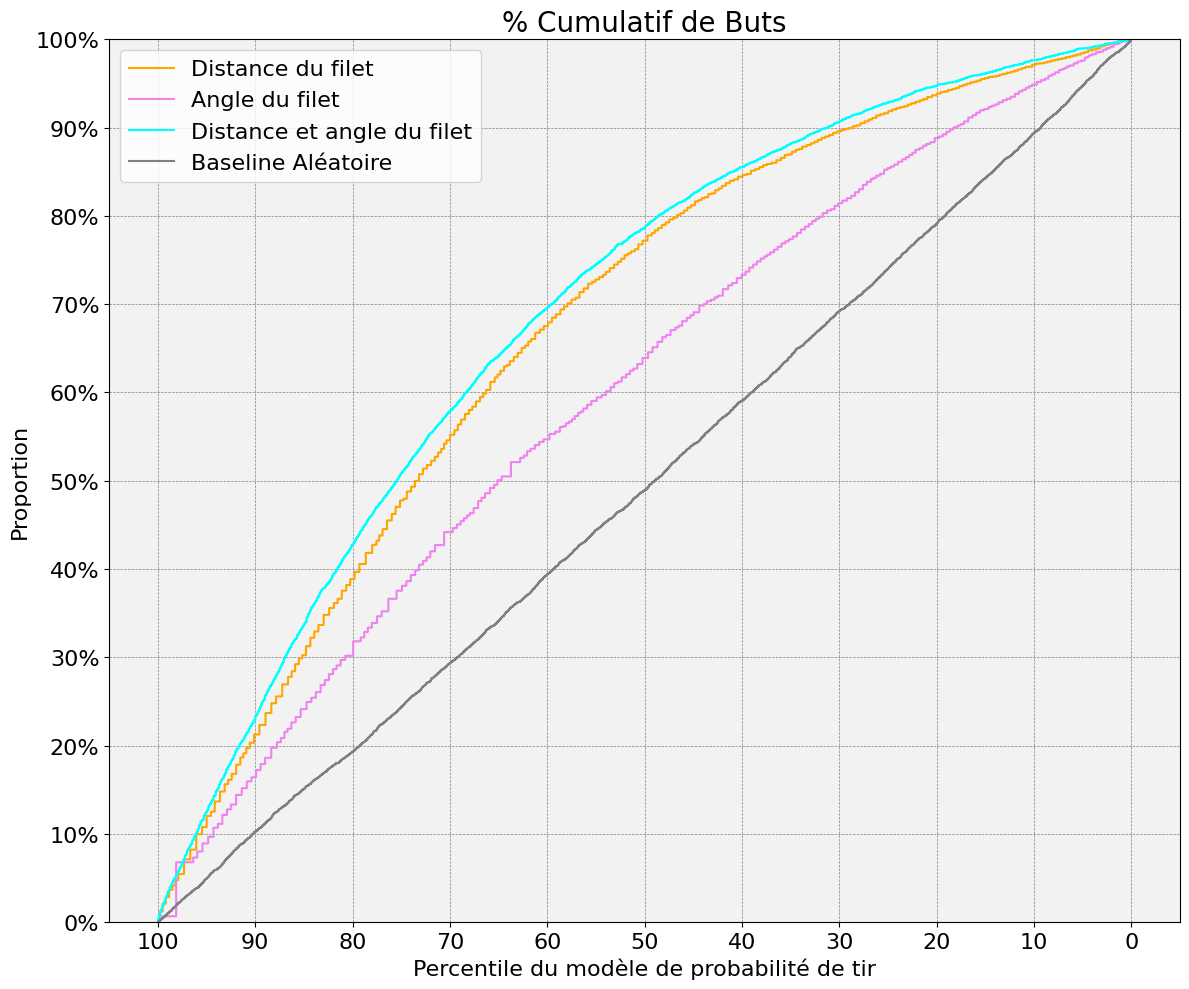

In [53]:
tracer_taux_cumulatif_deux_caracs(X, y)

In [55]:
data = pd.read_csv('Q4_train.csv', index_col=0)
X = data[['distance', 'angle' ]]
# Classification binaire utilisant isGoal comme cible
y = data[['isGoal']]


In [56]:
def tracer_calibration_deux_chars(X, y):

    fig = plt.figure(figsize=(20, 20))
    gs = GridSpec(4, 3)

    ax_courbe_calibration = fig.add_subplot(gs[:2, :2])
    
    liste_caracteristiques = [['distance'], ['angle'], ['distance', 'angle']]
    liste_couleurs = ['red', 'violet', 'cyan']
    liste_etiquettes = ['Distance du filet', 'Angle du filet', 'Distance et angle du filet']
    
    liste_caracteristiques.append('BaselineAléatoire')

    
    # Boucle pour tracer les courbes de calibration pour chaque caractéristique
    for i, caracteristique in enumerate(liste_caracteristiques):
            
        if caracteristique != 'BaselineAléatoire':
            
            X_val, y_val, y_pred, precision, pred_probs = XGB(X, y, caracteristique)   
            print(f'Score de précision : {precision}')
                
            y_val_est_but = y_val['isGoal']
            pred_probs_est_but = pred_probs[:, 1] 
            
            couleur_trace = liste_couleurs[i]
            etiquette_trace = liste_etiquettes[i]
            
        else:
            prob_but_aleatoire = np.random.uniform(0, 1, len(y_val))
            
            y_val_est_but = y_val['isGoal']
            pred_probs_est_but = prob_but_aleatoire.copy()
            
            couleur_trace = 'blue'
            etiquette_trace = 'Baseline Aléatoire'
            
        CalibrationDisplay.from_predictions(
            y_val_est_but, 
            pred_probs_est_but, 
            n_bins=50, 
            ax=ax_courbe_calibration, 
            color=couleur_trace, 
            label=etiquette_trace
        )
   
    ax = plt.gca()
    ax.set_facecolor('0.95')
    ax_courbe_calibration.grid()
    
    plt.title("Courbes de calibration", fontsize=20)
    plt.legend(loc=2, prop={'size': 16})
    plt.rc('xtick', labelsize=16)
    plt.rc('ytick', labelsize=16)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    plt.ylabel('Fraction de positifs', fontsize=20)
    plt.xlabel('Probabilité moyenne prédite', fontsize=20)
    plt.tight_layout()
    plt.savefig(f'2-5-1d_courbes_calibration.png')
    plt.show()

Score de précision : 0.9050856261171115
Score de précision : 0.9050856261171115
Score de précision : 0.9050856261171115


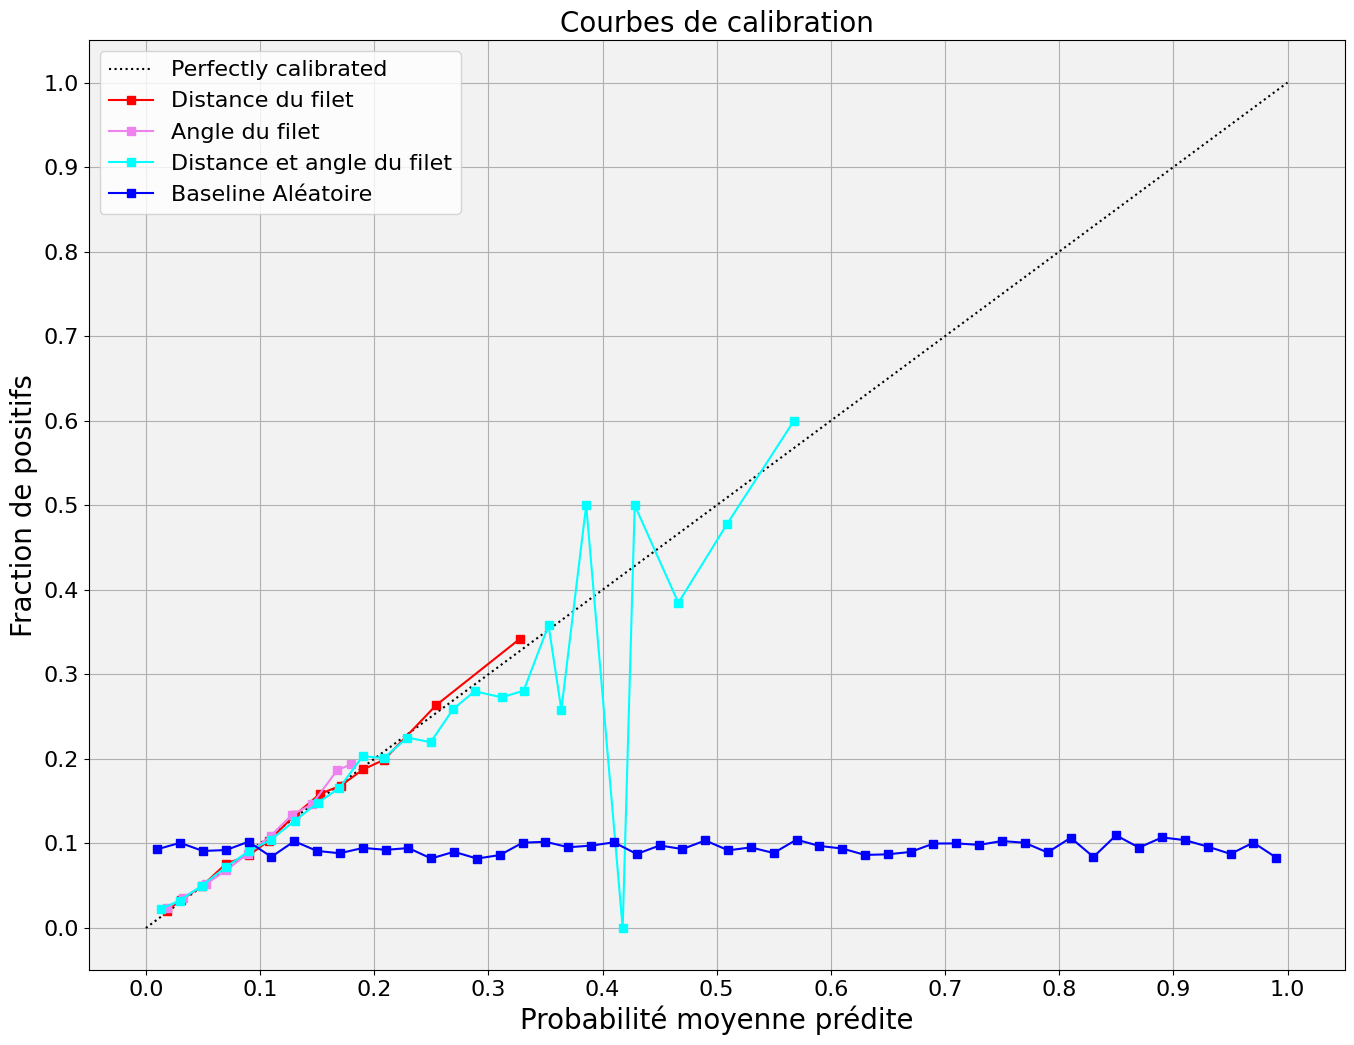

In [57]:
tracer_calibration_deux_chars(X, y)

c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:24:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


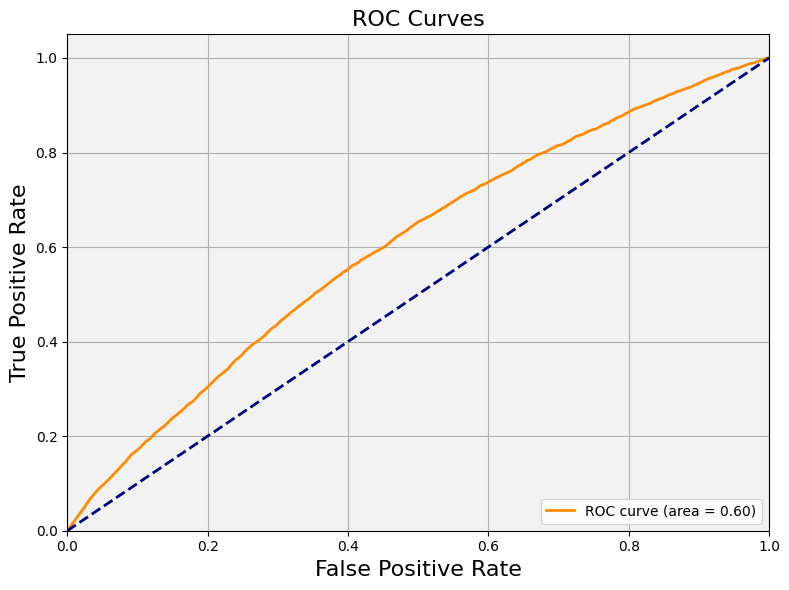

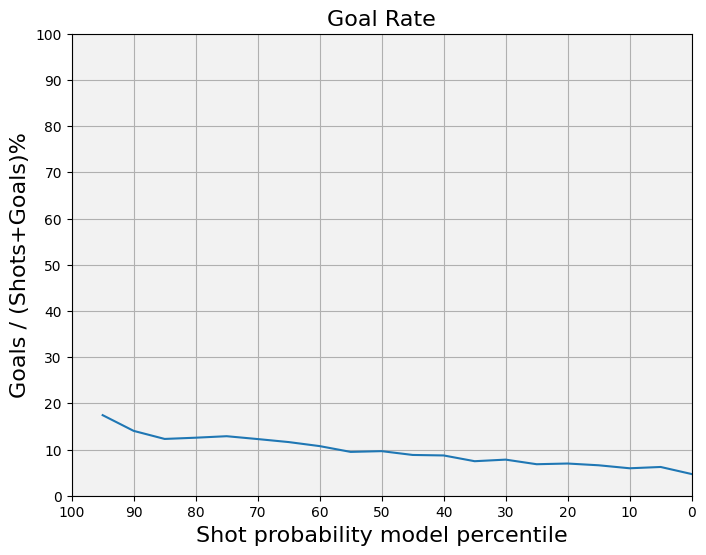

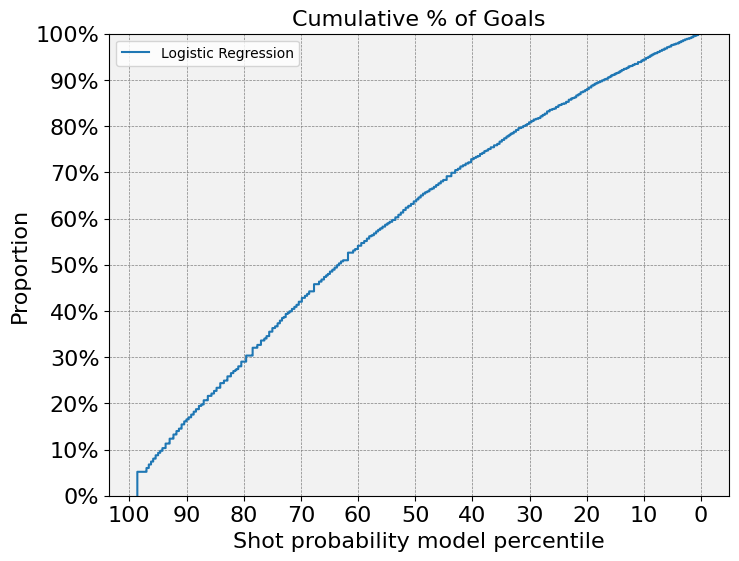

<Figure size 800x600 with 0 Axes>

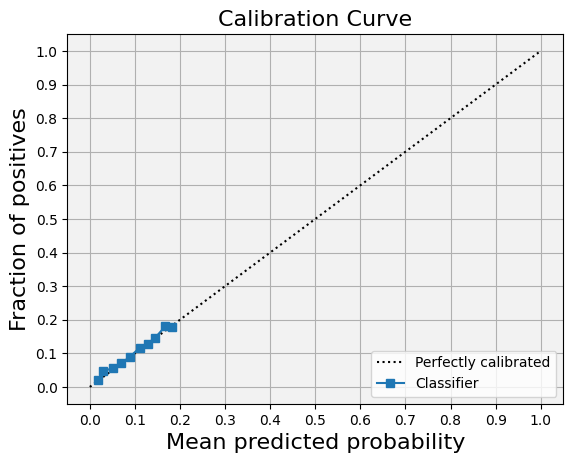

accuracy,▁
f1_score,▁
precision,▁
recall,▁
roc_auc,▁
accuracy,0.9035
f1_score,0
precision,0
recall,0
roc_auc,0.60154


Accuracy: 0.9035, F1: 0.0000, Precision: 0.0000, Recall: 0.0000, ROC AUC: 0.6015
Confusion Matrix:
[[59135     0]
 [ 6316     0]]


In [3]:
import wandb
import os
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import xgboost as xgb
from plot_metrics import *

# Initialiser l'authentification WandB
wandb.login(key=os.getenv("WANDB_API_KEY"))

# Lecture des données
data = pd.read_csv('Q2_train_data.csv', index_col=0)
X = data[['distance', 'angle']]
y = data[['isGoal']]

# Liste des combinaisons de caractéristiques
feature_list = [
    ['distance'],                # Index 0 : Distance uniquement
    ['angle'],                   # Index 1 : Angle uniquement
    ['distance', 'angle'],       # Index 2 : Distance et Angle
]
feature_name_list = ['Distance', 'Angle', 'Distance_Angle']

# Fonction pour entraîner le modèle XGBoost
def train_xgb(X, y, i):
    # Sélection des caractéristiques en fonction de l'index i
    selected_features = feature_list[i]
    selected_name = feature_name_list[i]

    # Initialiser une expérience WandB
    run = wandb.init(
        project="Milestone2_Q5",
        entity="thalia-cantero-udem",
        name=f"xgb_{selected_name.lower()}",
        tags=[selected_name, "XGBoost", "Baseline"],
    )

    # Filtrer les caractéristiques sélectionnées
    X_selected = X[selected_features]

    # Train/test split
    X_train, X_val, y_train, y_val = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    # Initialisation et entraînement du classificateur XGBoost
    clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
    y_train = y_train.values.ravel()
    clf.fit(X_train, y_train)

    # Prédictions et probabilités
    y_pred = clf.predict(X_val)
    pred_probs = clf.predict_proba(X_val)
    probs_isgoal = pred_probs[:, 1]

    # Calcul des métriques
    accuracy = metrics.accuracy_score(y_val, y_pred)
    f1_score = metrics.f1_score(y_val, y_pred)
    precision = metrics.precision_score(y_val, y_pred)
    recall = metrics.recall_score(y_val, y_pred)
    roc_auc = metrics.roc_auc_score(y_val, probs_isgoal)
    cf_matrix = metrics.confusion_matrix(y_val, y_pred)

    # Enregistrer les métriques dans WandB
    metrics_dict = {
        "accuracy": accuracy,
        "f1_score": f1_score,
        "precision": precision,
        "recall": recall,
        "roc_auc": roc_auc,
    }
    wandb.log(metrics_dict)

    # Visualisations des courbes
    plot_ROC(y_val, pred_probs)
    wandb.log({"roc_curve": wandb.Image("roc_curve.png")})

    df_percentile = calc_percentile(pred_probs, y_val)
    goal_rate_df = goal_rate(df_percentile)
    plot_goal_rates(goal_rate_df)
    wandb.log({"goal_rate_plot": wandb.Image("goal_rate_plot.png")})

    plot_cumulative_goal_rates(df_percentile)
    wandb.log({"cumulative_goal_rate": wandb.Image("cumulative_goal_rate.png")})

    plot_calibration_curve_prediction(y_val, pred_probs)
    wandb.log({"calibration_curve": wandb.Image("calibration_curve.png")})

    # Enregistrement du modèle
    model_filename = f"xgb_{selected_name.lower()}_model.pkl"
    pickle.dump(clf, open(model_filename, "wb"))

    # Enregistrer le modèle comme artefact
    artifact = wandb.Artifact(
        name=f"xgb_{selected_name.lower()}_model",
        type="model",
        description=f"XGBoost classifier trained with {selected_name} features",
        metadata=metrics_dict,
    )
    artifact.add_file(model_filename)
    run.log_artifact(artifact)

    # Fin de l'expérience WandB
    run.finish()

    return pred_probs, accuracy, f1_score, precision, recall, roc_auc, cf_matrix


if __name__ == "__main__":
    # Sélectionnez 0, 1 ou 2 pour choisir les caractéristiques
    i = 1  # Par exemple : 2 pour Distance et Angle
    pred_probs, accuracy, f1_score, precision, recall, roc_auc, cf_matrix = train_xgb(X, y, i)
    print(f"Accuracy: {accuracy:.4f}, F1: {f1_score:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, ROC AUC: {roc_auc:.4f}")
    print("Confusion Matrix:")
    print(cf_matrix)

Question 2: 

### Question 2: 

Etapes:

Définition des hyperparamètres : Les distributions pour booster, gamma, learning_rate, max_depth, n_estimators, reg_alpha, et reg_lambda sont spécifiées dans param_distributions.
Initialisation de RandomizedSearchCV : La recherche est configurée pour 100 itérations aléatoires (n_iter=100) avec 5 folds de validation croisée.
Formation et recherche : Le modèle est entraîné sur X_train et y_train, et les performances sont évaluées avec le score AUC.
Meilleurs hyperparamètres : Les paramètres optimaux sont affichés.
Évaluation du modèle optimal : Le modèle est évalué sur les données de validation avec la courbe ROC et le score AUC.

In [58]:
# Read in data and assign X and y   %%% Dois je 
# utiliser ceux de la question 3 o u 4
data = pd.read_csv('Q4_train.csv', index_col=0)
print(data.columns)

Index(['period', 'shotType', 'coordinateX', 'coordinateY', 'emptynet',
       'lastEvent', 'lastCoordinateX', 'lastCoordinateY', 'lastDistance',
       'timeLastEvent', 'speed', 'rebound', 'distance', 'angle', 'gameSeconds',
       'chang_angle', 'non_gardiens_amicaux', 'non_gardiens_adverses',
       'isGoal'],
      dtype='object')


In [5]:
import pandas as pd
data = pd.read_csv('Q4_train.csv', index_col=0)
print(data.columns)

Index(['period', 'shotType', 'coordinateX', 'coordinateY', 'emptynet',
       'lastEvent', 'lastCoordinateX', 'lastCoordinateY', 'lastDistance',
       'timeLastEvent', 'speed', 'rebound', 'distance', 'angle', 'gameSeconds',
       'chang_angle', 'non_gardiens_amicaux', 'non_gardiens_adverses',
       'isGoal'],
      dtype='object')


In [ ]:
import wandb
import os
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import xgboost as xgb
from plot_metrics import *

# Connexion à WandB (authentification via clé API)
wandb.login()

# Lecture des données
data = pd.read_csv('Q4_train.csv', index_col=0)
print(data.columns)
X = data[data.columns.tolist()[:-1]]
y = data[['isGoal']]

# Fonction pour entraîner, enregistrer et journaliser le modèle
def XGB_avec_wandb(X, y):
    # Initialiser une expérience WandB
    run = wandb.init(
        project="Milestone2_Q5",  # Nom du projet
        entity="thalia-cantero-udem",  # Organisation ou utilisateur
        name="xgb_toutes_chars_grid_search1",  # Nom de l'expérience
        tags=["RechercheGrille", "XGB", "ToutesCaractéristiques"],  # Tags pour organiser l'expérience
    )

    # Séparation des données d'entraînement et de validation
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    y_train = y_train.values.ravel()

    # Classificateur XGBoost
    model = xgb.XGBClassifier()

    # Hyperparamètres pour la recherche
    params = {
        'n_estimators': [100, 200, 500],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.05, 0.1],
        'booster': ['gbtree', 'gblinear', 'dart'],
        'gamma': [0, 0.5, 1],
        'reg_alpha': [0, 0.5, 1],
        'reg_lambda': [0.5, 1, 5],
    }

    # Recherche aléatoire sur les hyperparamètres
    recherche = RandomizedSearchCV(
        estimator=model,
        param_distributions=params,
        scoring='roc_auc',
        refit=True,
        cv=5,
        verbose=10,
        n_iter=100,
    )

    recherche.fit(X_train, y_train)

    # Meilleurs paramètres et score
    meilleurs_params = recherche.best_params_
    meilleur_score_grille = recherche.best_score_
    print('Meilleur score (grille) :', meilleur_score_grille)
    print('Meilleurs paramètres :', meilleurs_params)

    # Prédictions sur l'ensemble de validation
    y_pred = recherche.predict(X_val)
    pred_probs = recherche.predict_proba(X_val)
    probs_isgoal = pred_probs[:, 1]

    # Métriques d'évaluation du modèle
    exactitude = metrics.accuracy_score(y_val, y_pred)
    score_f1 = metrics.f1_score(y_val, y_pred)
    précision = metrics.precision_score(y_val, y_pred)
    rappel = metrics.recall_score(y_val, y_pred)
    matrice_confusion = metrics.confusion_matrix(y_val, y_pred)
    roc_auc = metrics.roc_auc_score(y_val, probs_isgoal)

    # Enregistrement du modèle localement
    nom_fichier_modele = "xgb_toutes_chars_grid_search1.pkl"
    pickle.dump(recherche, open(nom_fichier_modele, "wb"))

    # Enregistrement du modèle comme artefact dans WandB
    artifact = wandb.Artifact(
        name="xgb_toutes_chars_grid_search1_model",
        type="model",
        description="XGBoost avec recherche de grille sur toutes les caractéristiques",
        metadata={
            "Meilleur score (grille)": meilleur_score_grille,
            "Exactitude": exactitude,
            "Score F1": score_f1,
            "Précision": précision,
            "Rappel": rappel,
            "AUC ROC": roc_auc,
        },
    )
    artifact.add_file(nom_fichier_modele)
    run.log_artifact(artifact)

    # Courbe ROC
    plot_ROC(y_val, pred_probs)
    wandb.log({"Courbe ROC": wandb.Image("roc_curve.png")})

    # Autres graphiques
    df_percentile = calc_percentile(pred_probs, y_val)
    goal_rate_df = goal_rate(df_percentile)
    plot_goal_rates(goal_rate_df)
    wandb.log({"Taux de but": wandb.Image("goal_rate_plot.png")})

    plot_cumulative_goal_rates(df_percentile)
    wandb.log({"Taux cumulé de but": wandb.Image("cumulative_goal_rate.png")})

    plot_calibration_curve_prediction(y_val, pred_probs)
    wandb.log({"Courbe de calibration": wandb.Image("calibration_curve.png")})

    # Fin de l'expérience
    run.finish()

    return pred_probs, exactitude, score_f1, précision, rappel, roc_auc, matrice_confusion, meilleur_score_grille


if __name__ == "__main__":
    pred_probs, exactitude, score_f1, précision, rappel, roc_auc, matrice_confusion, meilleur_score_grille = XGB_avec_wandb(X, y)
    print(meilleur_score_grille, exactitude, score_f1, précision, rappel, roc_auc)
    print(matrice_confusion)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Index(['period', 'shotType', 'coordinateX', 'coordinateY', 'emptynet',
       'lastEvent', 'lastCoordinateX', 'lastCoordinateY', 'lastDistance',
       'timeLastEvent', 'speed', 'rebound', 'distance', 'angle', 'gameSeconds',
       'chang_angle', 'non_gardiens_amicaux', 'non_gardiens_adverses',
       'isGoal'],
      dtype='object')


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5; 1/100] START booster=gblinear, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=1, reg_lambda=5


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:06:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "gamma", "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5; 1/100] END booster=gblinear, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=1, reg_lambda=5;, score=0.631 total time=   1.9s
[CV 2/5; 1/100] START booster=gblinear, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=1, reg_lambda=5


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:06:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "gamma", "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5; 1/100] END booster=gblinear, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=1, reg_lambda=5;, score=0.637 total time=   1.5s
[CV 3/5; 1/100] START booster=gblinear, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=1, reg_lambda=5


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:06:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "gamma", "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5; 1/100] END booster=gblinear, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=1, reg_lambda=5;, score=0.636 total time=   1.5s
[CV 4/5; 1/100] START booster=gblinear, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=1, reg_lambda=5


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:06:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "gamma", "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5; 1/100] END booster=gblinear, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=1, reg_lambda=5;, score=0.639 total time=   1.5s
[CV 5/5; 1/100] START booster=gblinear, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=1, reg_lambda=5


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:06:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "gamma", "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5; 1/100] END booster=gblinear, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=1, reg_lambda=5;, score=0.633 total time=   1.6s
[CV 1/5; 2/100] START booster=gblinear, gamma=0.5, learning_rate=0.01, max_depth=6, n_estimators=200, reg_alpha=0.5, reg_lambda=0.5


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:06:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "gamma", "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5; 2/100] END booster=gblinear, gamma=0.5, learning_rate=0.01, max_depth=6, n_estimators=200, reg_alpha=0.5, reg_lambda=0.5;, score=0.679 total time=   3.1s
[CV 2/5; 2/100] START booster=gblinear, gamma=0.5, learning_rate=0.01, max_depth=6, n_estimators=200, reg_alpha=0.5, reg_lambda=0.5


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:06:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "gamma", "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5; 2/100] END booster=gblinear, gamma=0.5, learning_rate=0.01, max_depth=6, n_estimators=200, reg_alpha=0.5, reg_lambda=0.5;, score=0.684 total time=   3.3s
[CV 3/5; 2/100] START booster=gblinear, gamma=0.5, learning_rate=0.01, max_depth=6, n_estimators=200, reg_alpha=0.5, reg_lambda=0.5


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:06:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "gamma", "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5; 2/100] END booster=gblinear, gamma=0.5, learning_rate=0.01, max_depth=6, n_estimators=200, reg_alpha=0.5, reg_lambda=0.5;, score=0.684 total time=   3.0s
[CV 4/5; 2/100] START booster=gblinear, gamma=0.5, learning_rate=0.01, max_depth=6, n_estimators=200, reg_alpha=0.5, reg_lambda=0.5


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:06:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "gamma", "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5; 2/100] END booster=gblinear, gamma=0.5, learning_rate=0.01, max_depth=6, n_estimators=200, reg_alpha=0.5, reg_lambda=0.5;, score=0.687 total time=   4.3s
[CV 5/5; 2/100] START booster=gblinear, gamma=0.5, learning_rate=0.01, max_depth=6, n_estimators=200, reg_alpha=0.5, reg_lambda=0.5


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:06:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "gamma", "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5; 2/100] END booster=gblinear, gamma=0.5, learning_rate=0.01, max_depth=6, n_estimators=200, reg_alpha=0.5, reg_lambda=0.5;, score=0.677 total time=   3.8s
[CV 1/5; 3/100] START booster=dart, gamma=0.5, learning_rate=0.05, max_depth=6, n_estimators=200, reg_alpha=1, reg_lambda=5
[CV 1/5; 3/100] END booster=dart, gamma=0.5, learning_rate=0.05, max_depth=6, n_estimators=200, reg_alpha=1, reg_lambda=5;, score=0.784 total time=11.2min
[CV 2/5; 3/100] START booster=dart, gamma=0.5, learning_rate=0.05, max_depth=6, n_estimators=200, reg_alpha=1, reg_lambda=5
[CV 2/5; 3/100] END booster=dart, gamma=0.5, learning_rate=0.05, max_depth=6, n_estimators=200, reg_alpha=1, reg_lambda=5;, score=0.790 total time=13.0min
[CV 3/5; 3/100] START booster=dart, gamma=0.5, learning_rate=0.05, max_depth=6, n_estimators=200, reg_alpha=1, reg_lambda=5
[CV 3/5; 3/100] END booster=dart, gamma=0.5, learning_rate=0.05, max_depth=6, n_estimators=200, reg_alpha=1, reg_lambda=5;, score=0.793 total time=12.4min


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:04:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "gamma", "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5; 6/100] END booster=gblinear, gamma=0, learning_rate=0.1, max_depth=6, n_estimators=100, reg_alpha=1, reg_lambda=1;, score=0.609 total time=   1.7s
[CV 2/5; 6/100] START booster=gblinear, gamma=0, learning_rate=0.1, max_depth=6, n_estimators=100, reg_alpha=1, reg_lambda=1


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:04:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "gamma", "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5; 6/100] END booster=gblinear, gamma=0, learning_rate=0.1, max_depth=6, n_estimators=100, reg_alpha=1, reg_lambda=1;, score=0.603 total time=   1.8s
[CV 3/5; 6/100] START booster=gblinear, gamma=0, learning_rate=0.1, max_depth=6, n_estimators=100, reg_alpha=1, reg_lambda=1


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:04:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "gamma", "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5; 6/100] END booster=gblinear, gamma=0, learning_rate=0.1, max_depth=6, n_estimators=100, reg_alpha=1, reg_lambda=1;, score=0.607 total time=   1.7s
[CV 4/5; 6/100] START booster=gblinear, gamma=0, learning_rate=0.1, max_depth=6, n_estimators=100, reg_alpha=1, reg_lambda=1


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:04:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "gamma", "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5; 6/100] END booster=gblinear, gamma=0, learning_rate=0.1, max_depth=6, n_estimators=100, reg_alpha=1, reg_lambda=1;, score=0.606 total time=   1.7s
[CV 5/5; 6/100] START booster=gblinear, gamma=0, learning_rate=0.1, max_depth=6, n_estimators=100, reg_alpha=1, reg_lambda=1


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:04:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "gamma", "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5; 6/100] END booster=gblinear, gamma=0, learning_rate=0.1, max_depth=6, n_estimators=100, reg_alpha=1, reg_lambda=1;, score=0.599 total time=   1.6s
[CV 1/5; 7/100] START booster=gbtree, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0, reg_lambda=5
[CV 1/5; 7/100] END booster=gbtree, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0, reg_lambda=5;, score=0.767 total time=   2.1s
[CV 2/5; 7/100] START booster=gbtree, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0, reg_lambda=5
[CV 2/5; 7/100] END booster=gbtree, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0, reg_lambda=5;, score=0.774 total time=   2.7s
[CV 3/5; 7/100] START booster=gbtree, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0, reg_lambda=5
[CV 3/5; 7/100] END booster=gbtree, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0, reg_lambda=5;, score=0.776 total time=   2.6s
[CV 4/5

c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:04:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "gamma", "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5; 8/100] END booster=gblinear, gamma=0.5, learning_rate=0.01, max_depth=3, n_estimators=200, reg_alpha=0.5, reg_lambda=5;, score=0.678 total time=   4.1s
[CV 2/5; 8/100] START booster=gblinear, gamma=0.5, learning_rate=0.01, max_depth=3, n_estimators=200, reg_alpha=0.5, reg_lambda=5


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:04:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "gamma", "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5; 8/100] END booster=gblinear, gamma=0.5, learning_rate=0.01, max_depth=3, n_estimators=200, reg_alpha=0.5, reg_lambda=5;, score=0.683 total time=   3.8s
[CV 3/5; 8/100] START booster=gblinear, gamma=0.5, learning_rate=0.01, max_depth=3, n_estimators=200, reg_alpha=0.5, reg_lambda=5


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:04:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "gamma", "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5; 8/100] END booster=gblinear, gamma=0.5, learning_rate=0.01, max_depth=3, n_estimators=200, reg_alpha=0.5, reg_lambda=5;, score=0.683 total time=   3.5s
[CV 4/5; 8/100] START booster=gblinear, gamma=0.5, learning_rate=0.01, max_depth=3, n_estimators=200, reg_alpha=0.5, reg_lambda=5


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:05:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "gamma", "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5; 8/100] END booster=gblinear, gamma=0.5, learning_rate=0.01, max_depth=3, n_estimators=200, reg_alpha=0.5, reg_lambda=5;, score=0.686 total time=   3.5s
[CV 5/5; 8/100] START booster=gblinear, gamma=0.5, learning_rate=0.01, max_depth=3, n_estimators=200, reg_alpha=0.5, reg_lambda=5


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:05:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "gamma", "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5; 8/100] END booster=gblinear, gamma=0.5, learning_rate=0.01, max_depth=3, n_estimators=200, reg_alpha=0.5, reg_lambda=5;, score=0.676 total time=   3.4s
[CV 1/5; 9/100] START booster=gblinear, gamma=0, learning_rate=0.05, max_depth=6, n_estimators=200, reg_alpha=0.5, reg_lambda=1


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:05:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "gamma", "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5; 9/100] END booster=gblinear, gamma=0, learning_rate=0.05, max_depth=6, n_estimators=200, reg_alpha=0.5, reg_lambda=1;, score=0.682 total time=   3.1s
[CV 2/5; 9/100] START booster=gblinear, gamma=0, learning_rate=0.05, max_depth=6, n_estimators=200, reg_alpha=0.5, reg_lambda=1


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:05:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "gamma", "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5; 9/100] END booster=gblinear, gamma=0, learning_rate=0.05, max_depth=6, n_estimators=200, reg_alpha=0.5, reg_lambda=1;, score=0.686 total time=   3.1s
[CV 3/5; 9/100] START booster=gblinear, gamma=0, learning_rate=0.05, max_depth=6, n_estimators=200, reg_alpha=0.5, reg_lambda=1


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:05:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "gamma", "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5; 9/100] END booster=gblinear, gamma=0, learning_rate=0.05, max_depth=6, n_estimators=200, reg_alpha=0.5, reg_lambda=1;, score=0.687 total time=   3.1s
[CV 4/5; 9/100] START booster=gblinear, gamma=0, learning_rate=0.05, max_depth=6, n_estimators=200, reg_alpha=0.5, reg_lambda=1


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:05:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "gamma", "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5; 9/100] END booster=gblinear, gamma=0, learning_rate=0.05, max_depth=6, n_estimators=200, reg_alpha=0.5, reg_lambda=1;, score=0.687 total time=   3.0s
[CV 5/5; 9/100] START booster=gblinear, gamma=0, learning_rate=0.05, max_depth=6, n_estimators=200, reg_alpha=0.5, reg_lambda=1


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:05:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "gamma", "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5; 9/100] END booster=gblinear, gamma=0, learning_rate=0.05, max_depth=6, n_estimators=200, reg_alpha=0.5, reg_lambda=1;, score=0.678 total time=   3.1s
[CV 1/5; 10/100] START booster=dart, gamma=0.5, learning_rate=0.05, max_depth=6, n_estimators=200, reg_alpha=0.5, reg_lambda=0.5
[CV 1/5; 10/100] END booster=dart, gamma=0.5, learning_rate=0.05, max_depth=6, n_estimators=200, reg_alpha=0.5, reg_lambda=0.5;, score=0.784 total time=10.5min
[CV 2/5; 10/100] START booster=dart, gamma=0.5, learning_rate=0.05, max_depth=6, n_estimators=200, reg_alpha=0.5, reg_lambda=0.5
[CV 2/5; 10/100] END booster=dart, gamma=0.5, learning_rate=0.05, max_depth=6, n_estimators=200, reg_alpha=0.5, reg_lambda=0.5;, score=0.790 total time=10.8min
[CV 3/5; 10/100] START booster=dart, gamma=0.5, learning_rate=0.05, max_depth=6, n_estimators=200, reg_alpha=0.5, reg_lambda=0.5
[CV 3/5; 10/100] END booster=dart, gamma=0.5, learning_rate=0.05, max_depth=6, n_estimators=200, reg_alpha=0.5, reg_lambda=0.5;, score

c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:55:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "gamma", "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5; 12/100] END booster=gblinear, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=500, reg_alpha=0, reg_lambda=1;, score=0.704 total time=  10.7s
[CV 2/5; 12/100] START booster=gblinear, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=500, reg_alpha=0, reg_lambda=1


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:55:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "gamma", "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5; 12/100] END booster=gblinear, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=500, reg_alpha=0, reg_lambda=1;, score=0.710 total time=   9.9s
[CV 3/5; 12/100] START booster=gblinear, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=500, reg_alpha=0, reg_lambda=1


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:55:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "gamma", "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5; 12/100] END booster=gblinear, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=500, reg_alpha=0, reg_lambda=1;, score=0.709 total time=  10.1s
[CV 4/5; 12/100] START booster=gblinear, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=500, reg_alpha=0, reg_lambda=1


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:55:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "gamma", "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5; 12/100] END booster=gblinear, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=500, reg_alpha=0, reg_lambda=1;, score=0.709 total time=  10.0s
[CV 5/5; 12/100] START booster=gblinear, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=500, reg_alpha=0, reg_lambda=1


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:55:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "gamma", "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5; 12/100] END booster=gblinear, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=500, reg_alpha=0, reg_lambda=1;, score=0.703 total time=  10.6s
[CV 1/5; 13/100] START booster=dart, gamma=0.5, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=1, reg_lambda=0.5
[CV 1/5; 13/100] END booster=dart, gamma=0.5, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=1, reg_lambda=0.5;, score=0.771 total time= 2.9min
[CV 2/5; 13/100] START booster=dart, gamma=0.5, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=1, reg_lambda=0.5
[CV 2/5; 13/100] END booster=dart, gamma=0.5, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=1, reg_lambda=0.5;, score=0.779 total time= 2.6min
[CV 3/5; 13/100] START booster=dart, gamma=0.5, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=1, reg_lambda=0.5
[CV 3/5; 13/100] END booster=dart, gamma=0.5, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=1, reg_lambda=0.5;, score=0.780 total 

c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:59:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "gamma", "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5; 18/100] END booster=gblinear, gamma=0, learning_rate=0.05, max_depth=6, n_estimators=200, reg_alpha=0, reg_lambda=5;, score=0.701 total time=   5.3s
[CV 2/5; 18/100] START booster=gblinear, gamma=0, learning_rate=0.05, max_depth=6, n_estimators=200, reg_alpha=0, reg_lambda=5


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:59:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "gamma", "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5; 18/100] END booster=gblinear, gamma=0, learning_rate=0.05, max_depth=6, n_estimators=200, reg_alpha=0, reg_lambda=5;, score=0.707 total time=   5.1s
[CV 3/5; 18/100] START booster=gblinear, gamma=0, learning_rate=0.05, max_depth=6, n_estimators=200, reg_alpha=0, reg_lambda=5


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:59:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "gamma", "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5; 18/100] END booster=gblinear, gamma=0, learning_rate=0.05, max_depth=6, n_estimators=200, reg_alpha=0, reg_lambda=5;, score=0.706 total time=   4.9s
[CV 4/5; 18/100] START booster=gblinear, gamma=0, learning_rate=0.05, max_depth=6, n_estimators=200, reg_alpha=0, reg_lambda=5


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:59:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "gamma", "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5; 18/100] END booster=gblinear, gamma=0, learning_rate=0.05, max_depth=6, n_estimators=200, reg_alpha=0, reg_lambda=5;, score=0.706 total time=   4.7s
[CV 5/5; 18/100] START booster=gblinear, gamma=0, learning_rate=0.05, max_depth=6, n_estimators=200, reg_alpha=0, reg_lambda=5


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:59:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "gamma", "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5; 18/100] END booster=gblinear, gamma=0, learning_rate=0.05, max_depth=6, n_estimators=200, reg_alpha=0, reg_lambda=5;, score=0.699 total time=   4.3s
[CV 1/5; 19/100] START booster=dart, gamma=0.5, learning_rate=0.05, max_depth=6, n_estimators=500, reg_alpha=0, reg_lambda=0.5
[CV 1/5; 19/100] END booster=dart, gamma=0.5, learning_rate=0.05, max_depth=6, n_estimators=500, reg_alpha=0, reg_lambda=0.5;, score=0.784 total time=77.5min
[CV 2/5; 19/100] START booster=dart, gamma=0.5, learning_rate=0.05, max_depth=6, n_estimators=500, reg_alpha=0, reg_lambda=0.5
[CV 2/5; 19/100] END booster=dart, gamma=0.5, learning_rate=0.05, max_depth=6, n_estimators=500, reg_alpha=0, reg_lambda=0.5;, score=0.789 total time=73.8min
[CV 3/5; 19/100] START booster=dart, gamma=0.5, learning_rate=0.05, max_depth=6, n_estimators=500, reg_alpha=0, reg_lambda=0.5
[CV 3/5; 19/100] END booster=dart, gamma=0.5, learning_rate=0.05, max_depth=6, n_estimators=500, reg_alpha=0, reg_lambda=0.5;, score=0.792 total 

Exception in thread IntMsgThr:
Traceback (most recent call last):
  File "c:\Python312\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\user\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Python312\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Python312\Lib\site-packages\wandb\sdk\wandb_run.py", line 325, in check_internal_messages
    self._loop_check_status(
  File "c:\Python312\Lib\site-packages\wandb\sdk\wandb_run.py", line 235, in _loop_check_status
    local_handle = request()
                   ^^^^^^^^^
  File "c:\Python312\Lib\site-packages\wandb\sdk\interface\interface.py", line 914, in deliver_internal_messages
    return self._deliver_internal_messages(internal_message)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\wandb\sdk\interface\interface_shared

[CV 4/5; 19/100] END booster=dart, gamma=0.5, learning_rate=0.05, max_depth=6, n_estimators=500, reg_alpha=0, reg_lambda=0.5;, score=0.788 total time=62.8min
[CV 5/5; 19/100] START booster=dart, gamma=0.5, learning_rate=0.05, max_depth=6, n_estimators=500, reg_alpha=0, reg_lambda=0.5


Index(['period', 'shotType', 'coordinateX', 'coordinateY', 'emptynet',
       'lastEvent', 'lastCoordinateX', 'lastCoordinateY', 'lastDistance',
       'timeLastEvent', 'speed', 'rebound', 'distance', 'angle', 'gameSeconds',
       'chang_angle', 'non_gardiens_amicaux', 'non_gardiens_adverses',
       'isGoal'],
      dtype='object')


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5; 1/100] START booster=gbtree, gamma=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, reg_alpha=0, reg_lambda=1
[CV 1/5; 1/100] END booster=gbtree, gamma=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, reg_alpha=0, reg_lambda=1;, score=0.784 total time=   1.5s
[CV 2/5; 1/100] START booster=gbtree, gamma=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, reg_alpha=0, reg_lambda=1
[CV 2/5; 1/100] END booster=gbtree, gamma=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, reg_alpha=0, reg_lambda=1;, score=0.790 total time=   1.5s
[CV 3/5; 1/100] START booster=gbtree, gamma=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, reg_alpha=0, reg_lambda=1
[CV 3/5; 1/100] END booster=gbtree, gamma=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, reg_alpha=0, reg_lambda=1;, score=0.793 total time=   1.3s
[CV 4/5; 1/100] START booster=gbtree, gamma=0.5, learning_rate=0.1, max_depth=6, n_estimators=

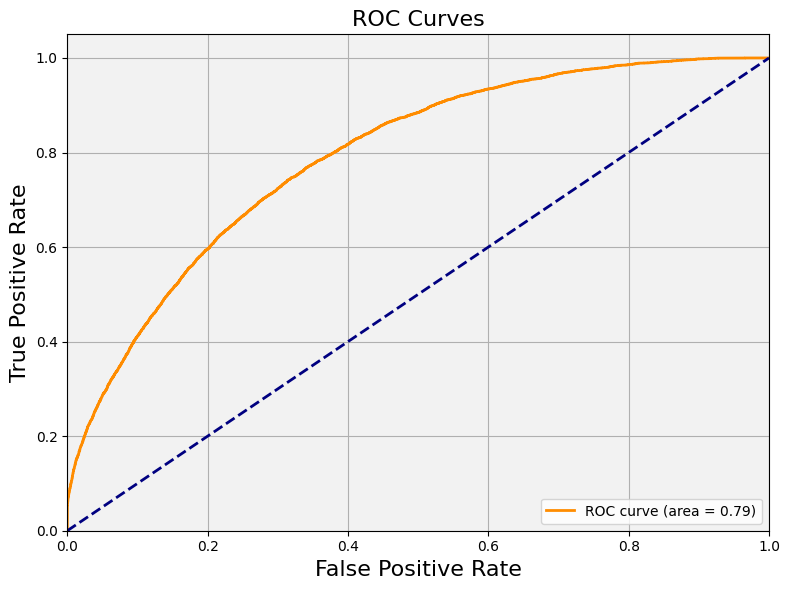

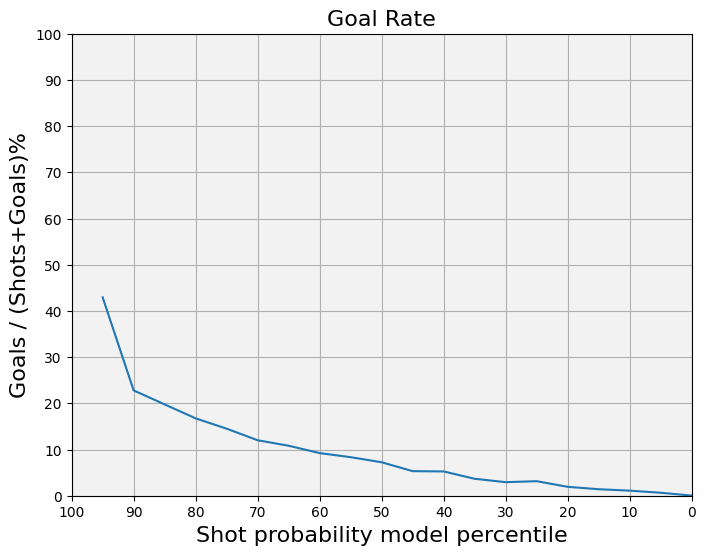

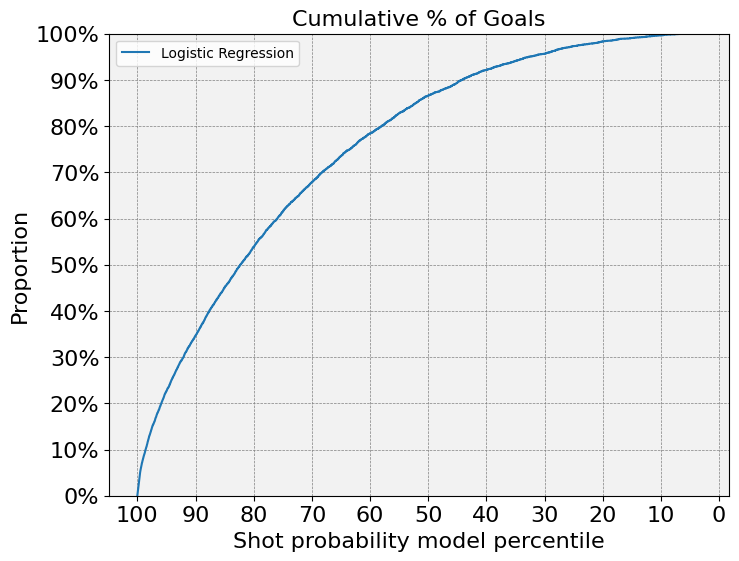

<Figure size 800x600 with 0 Axes>

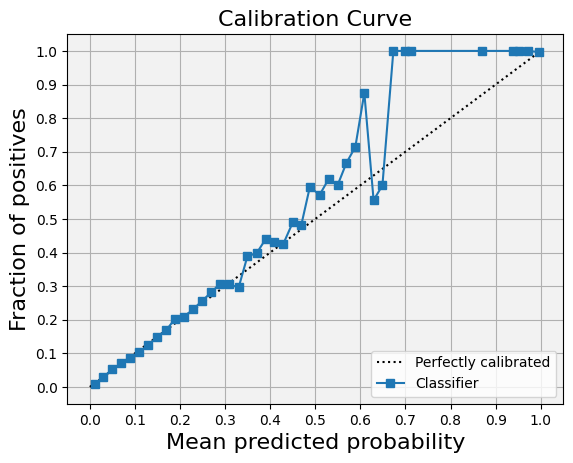

0.788017198641916 0.9103866542415864 0.11921921921921921 0.8881431767337807 0.06389827780460325 0.7905805385809251
[[59196    50]
 [ 5816   397]]


In [41]:
import wandb
import os
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import xgboost as xgb
from plot_metrics import *
import joblib

# Connexion à WandB (authentification via clé API)
wandb.login()

# Lecture des données
data = pd.read_csv('Q4_train.csv', index_col=0)
print(data.columns)
X = data[data.columns.tolist()[:-1]]
y = data[['isGoal']]

# Fonction pour entraîner, enregistrer et journaliser le modèle
def XGB_avec_wandb(X, y):
    # Initialiser une expérience WandB
    run = wandb.init(
        project="Milestone2_Q5",  # Nom du projet
        entity="thalia-cantero-udem",  # Organisation ou utilisateur
        name="xgb_toutes_chars_grid_search1",  # Nom de l'expérience
        tags=["RechercheGrille", "XGB", "ToutesCaractéristiques"],  # Tags pour organiser l'expérience
    )

    # Séparation des données d'entraînement et de validation
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    y_train = y_train.values.ravel()

    # Classificateur XGBoost
    model = xgb.XGBClassifier()

    # Hyperparamètres pour la recherche
    params = {
        'n_estimators': [100, 200],
        'max_depth': [ 6, 10],
        'learning_rate': [0.05, 0.1],
        'booster': ['gbtree'],
        'gamma': [0, 0.5, 1],
        'reg_alpha': [0, 0.5, 1],
        'reg_lambda': [0.5, 1, 5],
         
    }

    # Recherche aléatoire sur les hyperparamètres
    recherche = RandomizedSearchCV(
        estimator=model,
        param_distributions=params,
        scoring='roc_auc',
        refit=True,
        cv=5,
        verbose=10,
        n_iter=100,
        #n_jobs=-1  # Utilise tous les cœurs disponibles pour l'entraînement

    )

    recherche.fit(X_train, y_train)

    # Meilleurs paramètres et score
    meilleurs_params = recherche.best_params_
    meilleur_score_grille = recherche.best_score_
    print('Meilleur score (grille) :', meilleur_score_grille)
    print('Meilleurs paramètres :', meilleurs_params)

    # Prédictions sur l'ensemble de validation
    y_pred = recherche.predict(X_val)
    pred_probs = recherche.predict_proba(X_val)
    probs_isgoal = pred_probs[:, 1]

    # Métriques d'évaluation du modèle
    exactitude = metrics.accuracy_score(y_val, y_pred)
    score_f1 = metrics.f1_score(y_val, y_pred)
    précision = metrics.precision_score(y_val, y_pred)
    rappel = metrics.recall_score(y_val, y_pred)
    matrice_confusion = metrics.confusion_matrix(y_val, y_pred)
    roc_auc = metrics.roc_auc_score(y_val, probs_isgoal)

    # Enregistrement du modèle localement
    nom_fichier_modele = "xgb_toutes_chars_grid_search1.pkl"
    pickle.dump(recherche, open(nom_fichier_modele, "wb"))

    # Enregistrement du modèle comme artefact dans WandB
    artifact = wandb.Artifact(
        name="xgb_toutes_chars_grid_search1_model",
        type="model",
        description="XGBoost avec recherche de grille sur toutes les caractéristiques",
        metadata={
            "Meilleur score (grille)": meilleur_score_grille,
            "Exactitude": exactitude,
            "Score F1": score_f1,
            "Précision": précision,
            "Rappel": rappel,
            "AUC ROC": roc_auc,
        },
    )
    artifact.add_file(nom_fichier_modele)
    run.log_artifact(artifact)

    # Courbe ROC
    plot_ROC(y_val, pred_probs)
    wandb.log({"Courbe ROC": wandb.Image("roc_curve.png")})

    # Autres graphiques
    df_percentile = calc_percentile(pred_probs, y_val)
    goal_rate_df = goal_rate(df_percentile)
    plot_goal_rates(goal_rate_df)
    wandb.log({"Taux de but": wandb.Image("goal_rate_plot.png")})

    plot_cumulative_goal_rates(df_percentile)
    wandb.log({"Taux cumulé de but": wandb.Image("cumulative_goal_rate.png")})

    plot_calibration_curve_prediction(y_val, pred_probs)
    wandb.log({"Courbe de calibration": wandb.Image("calibration_curve.png")})

    # Fin de l'expérience
    run.finish()

    return pred_probs, exactitude, score_f1, précision, rappel, roc_auc, matrice_confusion, meilleur_score_grille


if __name__ == "__main__":
    pred_probs, exactitude, score_f1, précision, rappel, roc_auc, matrice_confusion, meilleur_score_grille = XGB_avec_wandb(X, y)
    print(meilleur_score_grille, exactitude, score_f1, précision, rappel, roc_auc)
    print(matrice_confusion)

In [9]:
import joblib

best_modele_xgb = joblib.load("xgb_toutes_chars_grid_search1.pkl") 
best_modele_xgb

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=100,
                   param_distributions={'booster': ['gbtree'],
                                        'gamma': [0, 0.5, 1],
                                        'learning_rate': [0.05, 0.1],
                                        'max_depth': [6, 10],
                                        'n_estimators': [100, 200],
                                        'reg_alpha': [0, 0.5, 1],
                                        'reg_lambda': [0.5, 1, 5]},
                   scoring='roc_auc', verbose=10)

In [10]:
xgb_best_params = best_modele_xgb.best_params_
xgb_best_params

{'reg_lambda': 5,
 'reg_alpha': 0,
 'n_estimators': 200,
 'max_depth': 6,
 'learning_rate': 0.1,
 'gamma': 1,
 'booster': 'gbtree'}

In [12]:
from sklearn.metrics import roc_curve, auc
X_train,X_val,y_train,y_val = train_test_split(X, y, test_size=0.2, random_state=42)
y_pred = best_modele_xgb.predict(X_val)
accuracy = metrics.accuracy_score(y_val, y_pred)

#Probability estimates
pred_probs = best_modele_xgb.predict_proba(X_val)
probs_isgoal = pred_probs[:,1]
    
#Model Evaultion Metrics
accuracy = metrics.accuracy_score(y_val, y_pred)
f1_score = metrics.f1_score(y_val, y_pred)
precision = metrics.precision_score(y_val, y_pred)
recall = metrics.recall_score(y_val, y_pred)
cf_matrix = metrics.confusion_matrix(y_val,y_pred)
roc_auc = metrics.roc_auc_score(y_val,probs_isgoal)


print(f' accuracy: {accuracy}')
print(f' f1_score: {f1_score}')
print(f' precision: {precision}')
print(f' recall: {recall}')
print(f' roc_auc: {roc_auc}')
print('Confusion Matrix')
print(cf_matrix)


 accuracy: 0.9103713775034754
 f1_score: 0.12524228418070674
 precision: 0.8502024291497976
 recall: 0.06760019314340898
 roc_auc: 0.7907449687811636
Confusion Matrix
[[59172    74]
 [ 5793   420]]


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import calibration_curve, CalibrationDisplay
import matplotlib.ticker as ticker

def tracer_ROC(y_val, pred_probs):
    """
    Trace une courbe ROC pour y (valeurs réelles) et les probabilités prédites par le modèle, 
    et calcule l'AUC.
    """
    probs_goal = pred_probs[:, 1]
    fpr, tpr, _ = roc_curve(y_val, probs_goal)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkblue",  # Couleur modifiée
        lw=lw,
        label="Courbe ROC (AUC = %0.2f)" % roc_auc,
    )
    # Ajouter une ligne de référence pour un classificateur aléatoire
    plt.plot([0, 1], [0, 1], color="orange", lw=lw, linestyle="--")  # Couleur modifiée
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("Taux de faux positifs", fontsize=16)
    plt.ylabel("Taux de vrais positifs", fontsize=16)
    plt.title('Courbes ROC', fontsize=16)
    plt.legend(loc="lower right")
    
    ax = plt.gca()
    ax.grid()
    ax.set_facecolor('0.95')
    plt.tight_layout()
    plt.savefig('courbe_roc.png')
    plt.show()

def calculer_percentile(pred_probs, y_val):
    """
    Calcule les percentiles des probabilités prédites et les combine avec la variable cible.
    """
    # Créer un DataFrame pour les probabilités de tir
    df_probs = pd.DataFrame(pred_probs)
    df_probs = df_probs.rename(columns={0: "Probabilité_non_but", 1: "Probabilité_but"})

    # Combiner la probabilité de but et la colonne cible
    df_probs = pd.concat([df_probs["Probabilité_but"].reset_index(drop=True), y_val["isGoal"].reset_index(drop=True)], axis=1)

    # Ajouter une colonne pour les percentiles
    percentiles = df_probs['Probabilité_but'].rank(pct=True)
    df_probs['Percentile'] = percentiles * 100
    return df_probs

def taux_de_but(df_percentile):
    """
    Calcule le taux de but par tranche de percentiles.
    """
    liste_taux = []
    largeur_bin = 5  # Largeur de chaque intervalle
    i = 0
    liste_intervalles = []

    while i < (100 - largeur_bin + 1):
        liste_intervalles.append(i)
        borne_inf = i
        borne_sup = i + largeur_bin

        # Trouver les lignes dans cet intervalle
        lignes_bin = df_percentile[(df_percentile['Percentile'] >= borne_inf) & (df_percentile['Percentile'] < borne_sup)]

        # Calculer le taux de but
        buts = lignes_bin['isGoal'].value_counts().get(1, 0)
        tirs = len(lignes_bin)
        taux = (buts / tirs) * 100 if tirs > 0 else 0
        liste_taux.append(taux)
        i += largeur_bin

    # Créer un DataFrame combinant les taux de but et les percentiles
    df_taux = pd.DataFrame(list(zip(liste_taux, liste_intervalles)), columns=['Taux', 'Percentile'])
    return df_taux

def tracer_taux_de_but(df_taux):
    """
    Trace le taux de but en fonction des percentiles.
    """
    plt.figure(figsize=(8, 6))
    ax = plt.gca()
    ax.grid()
    ax.set_facecolor('0.95')

    x = df_taux['Percentile']
    y = df_taux['Taux']
    plt.plot(x, y, color="green")  # Couleur modifiée

    ax.set_ylim([0, 100])
    ax.set_xlim([0, 100])
    ax.invert_xaxis()
    major_ticks = np.arange(0, 110, 10)
    ax.set_xticks(major_ticks)
    ax.set_yticks(major_ticks)

    plt.xlabel('Percentile du modèle de probabilité de tir', fontsize=16)
    plt.ylabel('Buts / (Tirs+Buts) %', fontsize=16)
    plt.title('Taux de Buts', fontsize=16)
    plt.savefig('taux_but.png')
    plt.show()

def tracer_taux_de_but_cumulatif(df_percentile):
    """
    Trace le taux de but cumulé pour chaque tranche de percentiles.
    """
    plt.figure(figsize=(8, 6))
    df_buts_uniquement = df_percentile[df_percentile['isGoal'] == 1]
    sns.ecdfplot(data=df_buts_uniquement, x=100 - df_buts_uniquement.Percentile, color="purple")  # Couleur modifiée

    ax = plt.gca()
    ax.grid()
    ax.set_facecolor('0.95')
    plt.yticks(np.arange(0, 1.05, 0.1))
    plt.xticks(np.arange(0, 100 * 1.01, 10))
    plt.xlabel('Percentile du modèle de probabilité de tir', fontsize=16)
    plt.ylabel('Proportion cumulée', fontsize=16)
    plt.title('Taux Cumulatif de Buts', fontsize=16)
    plt.savefig('taux_but_cumulatif.png')
    plt.show()

def tracer_courbe_de_calibration(y_val, pred_probs):
    """
    Trace la courbe de calibration du modèle.
    """
    plt.figure(figsize=(8, 6))
    CalibrationDisplay.from_predictions(y_val['isGoal'], pred_probs[:, 1], n_bins=50)

    ax = plt.gca()
    ax.grid()
    ax.set_facecolor('0.95')
    plt.xlabel('Probabilité moyenne prédite', fontsize=16)
    plt.ylabel('Fraction de positifs', fontsize=16)
    plt.title('Courbe de Calibration', fontsize=16)
    plt.savefig('courbe_calibration.png')
    plt.show()


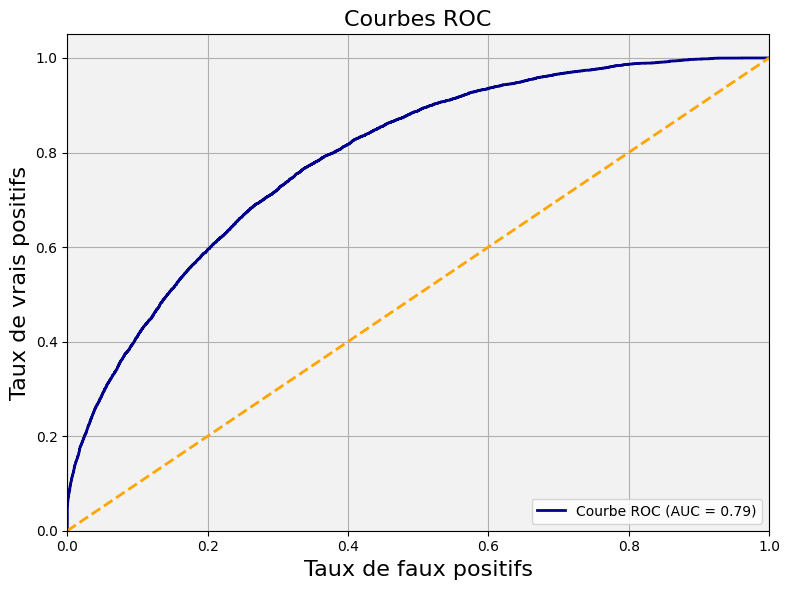

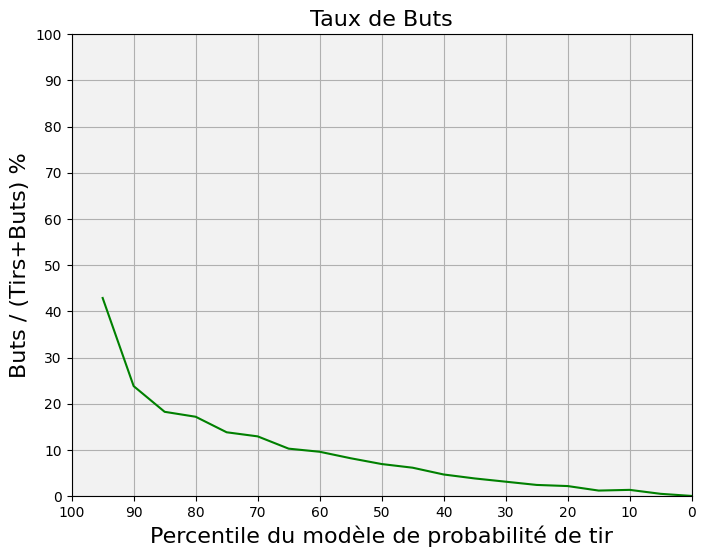

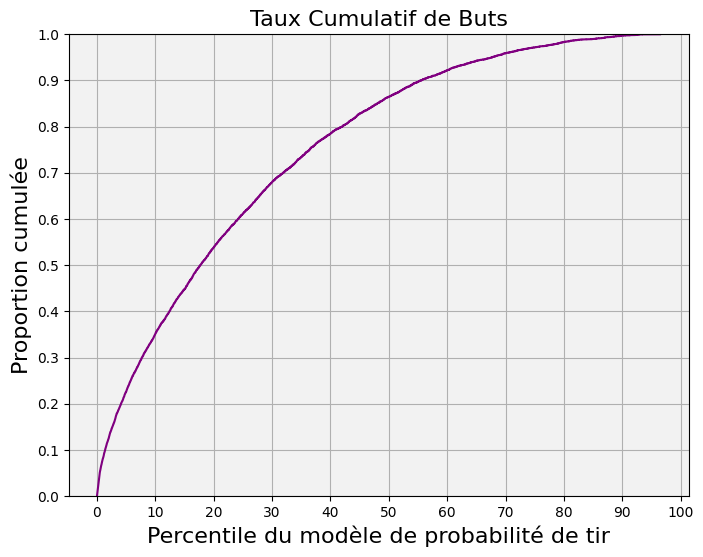

<Figure size 800x600 with 0 Axes>

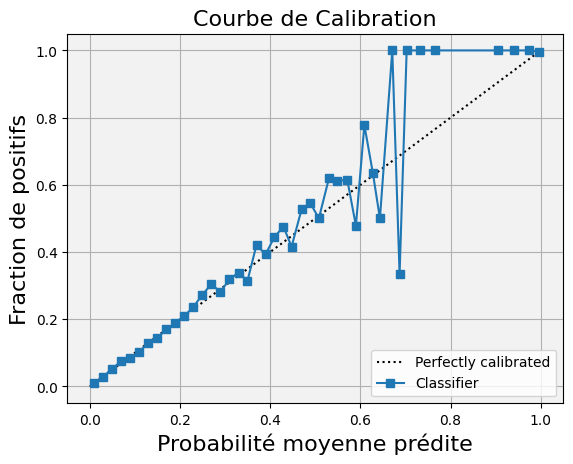

In [14]:
#ROC AUC Curve
tracer_ROC(y_val, pred_probs)
# Tracer le taux de buts
df_percentile =  calculer_percentile(pred_probs, y_val)
goal_rate_df = taux_de_but(df_percentile)
tracer_taux_de_but(goal_rate_df)
    
# Taux de buts cumulatif
tracer_taux_de_but_cumulatif(df_percentile)
    
#Courbe de calibration 
tracer_courbe_de_calibration(y_val, pred_probs)
    

 ### Question 5_3

Repartition en playoff ou non

Penser a remplacer le gameID pour extraire plus d'infos pertinentes

X['season'] = X['gameId'].str[:4].astype(int)  # Année de la saison
X['isPlayoff'] = X['gameId'].str[4:5].apply(lambda x: 1 if x == '3' else 0)  # Saison régulière ou playoffs
X['matchNumber'] = X['gameId'].str[5:].astype(int)  # Numéro de match

#### Methode Lasso via un classifieur SVM linéaire (LinearSVC)

Cette partie effectue une sélection de caractéristiques (features) basée sur la régularisation L1 via une SVM linéaire, puis entraîne un modèle XGBoost en utilisant les caractéristiques sélectionnées. 

1- Une liste de valeurs pour l'hyperparamètre C est définie, qui contrôle le compromis entre la marge du séparateur et l'erreur de classification.
Petite valeur de C : Encourage une plus grande régularisation (moins de caractéristiques sélectionnées).
Grande valeur de C : Réduit la régularisation (plus de caractéristiques sélectionnées).

2- Un modèle SVM linéaire est entraîné avec la pénalité L1 pour forcer certaines caractéristiques à avoir des coefficients de poids nuls.
Les coefficients non nuls correspondent aux caractéristiques importantes.

3- Le modèle XGBoost est entraîné sur les caractéristiques sélectionnées pour évaluer les performances.
Les métriques de classification (précision, score F1, AUC, etc.) sont calculées. Pour chaque valeur de C, le modèle SVM est entraîné, et les caractéristiques sélectionnées sont ensuite utilisées pour entraîner le modèle XGBoost (comparer les effets des différentes intensités de régularisation)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.metrics import roc_curve, auc
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker

In [3]:
def XGB(X, y):
    """
    Fonction pour entraîner un classificateur XGBoost et évaluer ses performances.

    Arguments :
    X : pd.DataFrame - Données d'entrée (caractéristiques).
    y : pd.Series - Labels/cibles.

    Retourne :
    - pred_probs : np.ndarray - Probabilités prédites.
    - accuracy : float - Précision du modèle.
    - f1_score : float - Score F1.
    - precision : float - Précision (proportion de vrais positifs sur les prédictions positives).
    - recall : float - Rappel (proportion de vrais positifs détectés).
    - roc_auc : float - Aire sous la courbe ROC.
    - cf_matrix : np.ndarray - Matrice de confusion.
    """

    # Diviser les données en ensembles d'entraînement et de validation
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialiser le classificateur XGBoost
    clf = xgb.XGBClassifier()

    # Entraîner le modèle sur les données d'entraînement
    clf.fit(X_train, y_train)
    
    # Faire des prédictions sur l'ensemble de validation
    y_pred = clf.predict(X_val)
    
    # Obtenir les probabilités prédites
    pred_probs = clf.predict_proba(X_val)
    
    # Calculer les métriques d'évaluation du modèle
    accuracy = metrics.accuracy_score(y_val, y_pred)  # Précision
    f1_score = metrics.f1_score(y_val, y_pred)       # Score F1
    precision = metrics.precision_score(y_val, y_pred)  # Précision (positifs prédits corrects)
    recall = metrics.recall_score(y_val, y_pred)        # Rappel (sensibilité)
    cf_matrix = metrics.confusion_matrix(y_val, y_pred)  # Matrice de confusion
    
    # Calculer l'AUC ROC
    probs_isgoal = pred_probs[:, 1]  # Probabilités pour la classe positive
    roc_auc = metrics.roc_auc_score(y_val, probs_isgoal)
    
    # Retourner les métriques et résultats
    return pred_probs, accuracy, f1_score, precision, recall, roc_auc, cf_matrix

In [6]:
import pandas as pd

# Classification binaire utilisant isGoal comme cible
X = data[data.columns.tolist()[:-1]]
y = data['isGoal']  

# Enlever les lignes avec des valeurs manquantes dans X


# Convertir y en tableau NumPy unidimensionnel
y = y.values.ravel()

In [8]:
import numpy as np
col_list = X.columns.to_list()
feature_names = np.array(X.columns.to_list())
print(feature_names)

['period' 'shotType' 'coordinateX' 'coordinateY' 'emptynet' 'lastEvent'
 'lastCoordinateX' 'lastCoordinateY' 'lastDistance' 'timeLastEvent'
 'speed' 'rebound' 'distance' 'angle' 'gameSeconds' 'chang_angle'
 'non_gardiens_amicaux' 'non_gardiens_adverses']


In [9]:
from sklearn.preprocessing import MinMaxScaler 
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

col_list = X.columns.to_list()
feature_names = np.array(X.columns.to_list())
print(feature_names)


# Normalisation des données
min_max_scaler = MinMaxScaler()
X[col_list] = min_max_scaler.fit_transform(X[col_list])

# y = y.values.ravel()

# Lasso SVC
# Configuration de la régularisation L1
C_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 50, 100, 1000]

for c in C_list:
    # SVM linéaire avec régularisation L1
    lsvc = LinearSVC(C=c, penalty="l1", max_iter=10000, dual=False).fit(X, y)
     
    # Sélection des caractéristiques
    selector = SelectFromModel(lsvc)

    selector.fit(X, y)

    # Obtenir les noms des caractéristiques sélectionnées
    selected_features = feature_names[selector.get_support()]
    print(f'Caractéristiques sélectionnées pour C={c} : {selected_features}')
    
    non_selected_features = feature_names[~selector.get_support()]
    print(f'Caractéristiques non sélectionnées pour C={c} : {non_selected_features}')

    # Transformer les données en utilisant uniquement les caractéristiques sélectionnées
    features = selector.transform(X)
    print('Dimensions des caractéristiques sélectionnées : ', features.shape)

    # Entraîner le modèle XGBoost avec les caractéristiques sélectionnées
    pred_probs, accuracy, f1_score, precision, recall, roc_auc, cf_matrix = XGB(features, y)
    print(f'C : {c}, précision : {accuracy:6.4}, score F1 : {f1_score:6.4}, '
    f'précision : {precision:6.4}, rappel : {recall:6.4}, roc_auc : {roc_auc:6.4}')

['period' 'shotType' 'coordinateX' 'coordinateY' 'emptynet' 'lastEvent'
 'lastCoordinateX' 'lastCoordinateY' 'lastDistance' 'timeLastEvent'
 'speed' 'rebound' 'distance' 'angle' 'gameSeconds' 'chang_angle'
 'non_gardiens_amicaux' 'non_gardiens_adverses']


C:\Users\user\AppData\Local\Temp\ipykernel_9972\42122640.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col_list] = min_max_scaler.fit_transform(X[col_list])


Caractéristiques sélectionnées pour C=0.001 : ['shotType' 'emptynet' 'lastDistance' 'timeLastEvent' 'speed' 'rebound'
 'distance' 'non_gardiens_amicaux' 'non_gardiens_adverses']
Caractéristiques non sélectionnées pour C=0.001 : ['period' 'coordinateX' 'coordinateY' 'lastEvent' 'lastCoordinateX'
 'lastCoordinateY' 'angle' 'gameSeconds' 'chang_angle']
Dimensions des caractéristiques sélectionnées :  (327295, 9)
C : 0.001, précision : 0.9097, score F1 : 0.1298, précision : 0.7577, rappel : 0.07098, roc_auc :  0.776
Caractéristiques sélectionnées pour C=0.005 : ['shotType' 'coordinateY' 'emptynet' 'lastEvent' 'lastCoordinateX'
 'lastCoordinateY' 'lastDistance' 'speed' 'rebound' 'distance'
 'gameSeconds' 'non_gardiens_amicaux' 'non_gardiens_adverses']
Caractéristiques non sélectionnées pour C=0.005 : ['period' 'coordinateX' 'timeLastEvent' 'angle' 'chang_angle']
Dimensions des caractéristiques sélectionnées :  (327295, 13)
C : 0.005, précision : 0.9102, score F1 : 0.1264, précision : 0.8285

c:\Python312\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Caractéristiques sélectionnées pour C=0.05 : ['shotType' 'coordinateX' 'coordinateY' 'emptynet' 'lastEvent'
 'lastCoordinateX' 'lastCoordinateY' 'lastDistance' 'timeLastEvent'
 'speed' 'rebound' 'distance' 'gameSeconds' 'non_gardiens_amicaux'
 'non_gardiens_adverses']
Caractéristiques non sélectionnées pour C=0.05 : ['period' 'angle' 'chang_angle']
Dimensions des caractéristiques sélectionnées :  (327295, 15)
C : 0.05, précision : 0.9104, score F1 : 0.1398, précision : 0.7833, rappel : 0.07677, roc_auc : 0.7859


c:\Python312\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Caractéristiques sélectionnées pour C=0.1 : ['shotType' 'coordinateX' 'coordinateY' 'emptynet' 'lastEvent'
 'lastCoordinateX' 'lastCoordinateY' 'lastDistance' 'timeLastEvent'
 'speed' 'rebound' 'distance' 'angle' 'gameSeconds' 'non_gardiens_amicaux'
 'non_gardiens_adverses']
Caractéristiques non sélectionnées pour C=0.1 : ['period' 'chang_angle']
Dimensions des caractéristiques sélectionnées :  (327295, 16)
C : 0.1, précision : 0.9102, score F1 : 0.1421, précision : 0.7586, rappel : 0.07838, roc_auc : 0.7854
Caractéristiques sélectionnées pour C=0.5 : ['period' 'shotType' 'coordinateX' 'coordinateY' 'emptynet' 'lastEvent'
 'lastCoordinateX' 'lastCoordinateY' 'lastDistance' 'timeLastEvent'
 'speed' 'rebound' 'distance' 'angle' 'gameSeconds' 'chang_angle'
 'non_gardiens_amicaux' 'non_gardiens_adverses']
Caractéristiques non sélectionnées pour C=0.5 : []
Dimensions des caractéristiques sélectionnées :  (327295, 18)
C : 0.5, précision : 0.9104, score F1 : 0.1461, précision : 0.7641, rappel

c:\Python312\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Caractéristiques sélectionnées pour C=1.0 : ['period' 'shotType' 'coordinateX' 'coordinateY' 'emptynet' 'lastEvent'
 'lastCoordinateX' 'lastCoordinateY' 'lastDistance' 'timeLastEvent'
 'speed' 'rebound' 'distance' 'angle' 'gameSeconds' 'chang_angle'
 'non_gardiens_amicaux' 'non_gardiens_adverses']
Caractéristiques non sélectionnées pour C=1.0 : []
Dimensions des caractéristiques sélectionnées :  (327295, 18)
C : 1.0, précision : 0.9104, score F1 : 0.1461, précision : 0.7641, rappel : 0.0808, roc_auc : 0.7854
Caractéristiques sélectionnées pour C=50 : ['period' 'shotType' 'coordinateX' 'coordinateY' 'emptynet' 'lastEvent'
 'lastCoordinateX' 'lastCoordinateY' 'lastDistance' 'timeLastEvent'
 'speed' 'rebound' 'distance' 'angle' 'gameSeconds' 'chang_angle'
 'non_gardiens_amicaux' 'non_gardiens_adverses']
Caractéristiques non sélectionnées pour C=50 : []
Dimensions des caractéristiques sélectionnées :  (327295, 18)
C : 50, précision : 0.9104, score F1 : 0.1461, précision : 0.7641, rappel : 

Selection des carateristiques avec le best modele

In [43]:
def xgb_best_model(X, y):
    '''
    Arguments :
    X = pd.DataFrame X
    y = étiquettes cibles
    liste_caracteristiques = liste des caractéristiques
    '''
    
    X_train,X_val,y_train,y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    # Modèle XGB

    clf_best_model = xgb.XGBClassifier(
    reg_lambda=5,
    reg_alpha=0,
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    gamma=0.5,
    booster='gbtree',
    random_state=42  # Optionnel : pour assurer la reproductibilité
)
    
    y_train = y_train.ravel()
    clf_best_model.fit(X_train, y_train)
    
    # Prédiction sur l'ensemble de validation

    y_pred = clf_best_model.predict(X_val)
    precision = metrics.accuracy_score(y_val, y_pred)
    
         
    #Probability estimates
    pred_probs =  clf_best_model.predict_proba(X_val)
    probs_isgoal = pred_probs[:,1]
    
    #Model Evaultion Metrics
    accuracy = metrics.accuracy_score(y_val, y_pred)
    f1_score = metrics.f1_score(y_val, y_pred)
    precision = metrics.precision_score(y_val, y_pred)
    recall = metrics.recall_score(y_val, y_pred)
    cf_matrix = metrics.confusion_matrix(y_val,y_pred)
    roc_auc = metrics.roc_auc_score(y_val,probs_isgoal)
       
    return pred_probs, accuracy,f1_score, precision, recall, roc_auc, cf_matrix

In [93]:
from sklearn.preprocessing import MinMaxScaler 
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

X = X.copy()
tot_col = len(X.columns)

# Normalisation des données
min_max_scaler = MinMaxScaler()
X[col_list] = min_max_scaler.fit_transform(X[col_list])

# y = y.values.ravel()

# Lasso SVC
# Configuration de la régularisation L1
C_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 50, 100, 1000]

for c in C_list:
    # SVM linéaire avec régularisation L1
    lsvc = LinearSVC(C=c, penalty="l1", max_iter=10000, dual=False).fit(X, y)
     
    # Sélection des caractéristiques
    selector = SelectFromModel(lsvc)

    selector.fit(X, y)

    # Obtenir les noms des caractéristiques sélectionnées
    selected_features = feature_names[selector.get_support()]
    print(f'Caractéristiques sélectionnées pour C={c} : {selected_features}')
    
    # Transformer les données en utilisant uniquement les caractéristiques sélectionnées
    features = selector.transform(X)
    print('Dimensions des caractéristiques sélectionnées : ', features.shape)

    
    # Entraîner le modèle XGBoost avec les caractéristiques sélectionnées
    pred_probs, accuracy, f1_score, precision, recall, roc_auc, cf_matrix = xgb_best_model(features, y)
    
    print(f'C : {c}, précision : {accuracy:6.4}, score F1 : {f1_score:6.4}, '
          f'précision : {precision:6.4}, rappel : {recall:6.4}, roc_auc : {roc_auc:6.4}')

c:\Python312\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Caractéristiques sélectionnées pour C=0.001 : ['shotType' 'emptynet' 'lastDistance' 'distance' 'angle']
Dimensions des caractéristiques sélectionnées :  (235225, 5)
C : 0.001, précision : 0.9124, score F1 : 0.09649, précision : 0.9483, rappel : 0.05083, roc_auc : 0.7484


c:\Python312\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Caractéristiques sélectionnées pour C=0.005 : ['shotType' 'emptynet' 'lastCoordinateX' 'lastDistance' 'timeLastEvent'
 'rebound' 'distance' 'angle']
Dimensions des caractéristiques sélectionnées :  (235225, 8)
C : 0.005, précision : 0.9124, score F1 : 0.09998, précision : 0.9051, rappel : 0.05291, roc_auc :  0.764


c:\Python312\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Caractéristiques sélectionnées pour C=0.01 : ['shotType' 'coordinateY' 'emptynet' 'lastEvent' 'lastCoordinateX'
 'lastCoordinateY' 'lastDistance' 'timeLastEvent' 'rebound' 'distance'
 'angle' 'gameSeconds']
Dimensions des caractéristiques sélectionnées :  (235225, 12)
C : 0.01, précision : 0.9124, score F1 : 0.09967, précision : 0.9231, rappel : 0.05268, roc_auc : 0.7659


c:\Python312\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Caractéristiques sélectionnées pour C=0.05 : ['shotType' 'coordinateX' 'coordinateY' 'emptynet' 'lastEvent'
 'lastCoordinateX' 'lastCoordinateY' 'lastDistance' 'timeLastEvent'
 'rebound' 'distance' 'angle' 'gameSeconds']
Dimensions des caractéristiques sélectionnées :  (235225, 13)
C : 0.05, précision : 0.9126, score F1 : 0.1029, précision : 0.9147, rappel : 0.05453, roc_auc : 0.7655


c:\Python312\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Caractéristiques sélectionnées pour C=0.1 : ['shotType' 'coordinateX' 'coordinateY' 'emptynet' 'lastEvent'
 'lastCoordinateX' 'lastCoordinateY' 'lastDistance' 'timeLastEvent'
 'rebound' 'distance' 'angle' 'gameSeconds' 'vitesse_chang_angle']
Dimensions des caractéristiques sélectionnées :  (235225, 14)
C : 0.1, précision : 0.9126, score F1 : 0.1065, précision : 0.8909, rappel : 0.05661, roc_auc : 0.7659
Caractéristiques sélectionnées pour C=0.5 : ['shotType' 'coordinateX' 'coordinateY' 'emptynet' 'lastEvent'
 'lastCoordinateX' 'lastCoordinateY' 'lastDistance' 'timeLastEvent'
 'speed' 'rebound' 'distance' 'angle' 'gameSeconds' 'chang_angle'
 'vitesse_chang_angle']
Dimensions des caractéristiques sélectionnées :  (235225, 16)
C : 0.5, précision : 0.9126, score F1 : 0.1045, précision : 0.9057, rappel : 0.05545, roc_auc :  0.766


c:\Python312\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Caractéristiques sélectionnées pour C=1.0 : ['shotType' 'coordinateX' 'coordinateY' 'emptynet' 'lastEvent'
 'lastCoordinateX' 'lastCoordinateY' 'lastDistance' 'timeLastEvent'
 'speed' 'rebound' 'distance' 'angle' 'gameSeconds' 'chang_angle'
 'vitesse_chang_angle']
Dimensions des caractéristiques sélectionnées :  (235225, 16)
C : 1.0, précision : 0.9126, score F1 : 0.1045, précision : 0.9057, rappel : 0.05545, roc_auc :  0.766
Caractéristiques sélectionnées pour C=50 : ['period' 'shotType' 'coordinateX' 'coordinateY' 'emptynet' 'lastEvent'
 'lastCoordinateX' 'lastCoordinateY' 'lastDistance' 'timeLastEvent'
 'speed' 'rebound' 'distance' 'angle' 'gameSeconds' 'chang_angle'
 'vitesse_chang_angle']
Dimensions des caractéristiques sélectionnées :  (235225, 17)
C : 50, précision : 0.9126, score F1 : 0.1037, précision : 0.9084, rappel : 0.05499, roc_auc : 0.7657


c:\Python312\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Caractéristiques sélectionnées pour C=100 : ['period' 'shotType' 'coordinateX' 'coordinateY' 'emptynet' 'lastEvent'
 'lastCoordinateX' 'lastCoordinateY' 'lastDistance' 'timeLastEvent'
 'rebound' 'distance' 'angle' 'gameSeconds' 'chang_angle'
 'vitesse_chang_angle']
Dimensions des caractéristiques sélectionnées :  (235225, 16)
C : 100, précision : 0.9125, score F1 :  0.104, précision : 0.8985, rappel : 0.05522, roc_auc :  0.765
Caractéristiques sélectionnées pour C=1000 : ['period' 'shotType' 'coordinateX' 'coordinateY' 'emptynet' 'lastEvent'
 'lastCoordinateX' 'lastCoordinateY' 'lastDistance' 'timeLastEvent'
 'speed' 'rebound' 'distance' 'angle' 'gameSeconds' 'chang_angle'
 'vitesse_chang_angle']
Dimensions des caractéristiques sélectionnées :  (235225, 17)
C : 1000, précision : 0.9126, score F1 : 0.1037, précision : 0.9084, rappel : 0.05499, roc_auc : 0.7657


Finalement il n'ya pas beaucoup de changement a tester la selectiond es caracteristiques sur le meilleur modele ou le modele XGB normal utilisannt toutes les caracteristiques

In [89]:
col_list = X.columns.to_list()
feature_names = np.array(X.columns.to_list())
print(feature_names)

['period' 'shotType' 'coordinateX' 'coordinateY' 'emptynet' 'lastEvent'
 'lastCoordinateX' 'lastCoordinateY' 'lastDistance' 'timeLastEvent'
 'speed' 'rebound' 'distance' 'angle' 'gameSeconds' 'chang_angle'
 'vitesse_chang_angle']


Étapes pour sélectionner le meilleur C :
Performance globale :

roc_auc : C'est une métrique clé pour un problème de classification. Elle évalue la capacité du modèle à différencier entre les classes.
Score F1 : Mesure l'équilibre entre la précision et le rappel, utile si les classes sont déséquilibrées.
Nombre de caractéristiques sélectionnées :

Moins de caractéristiques peuvent simplifier le modèle, réduire le surajustement et accélérer le temps de calcul.
Toutefois, si trop peu de caractéristiques sont sélectionnées, la performance peut en souffrir.
Convergence :

Les warnings comme Liblinear failed to converge pour certains C suggèrent que le modèle a eu des difficultés à s'ajuster, indiquant que ce C n'est peut-être pas optimal.

Analyse des résultats :
Meilleur C basé sur les performances et les caractéristiques :
C=0.5 :
roc_auc = 0.7617 (le plus élevé parmi toutes les valeurs).
Score F1 = 0.1135 (le plus élevé).
16 caractéristiques sélectionnées (un bon compromis entre trop peu et trop nombreuses).
Autres observations :
C=0.05 et C=0.1 montrent une bonne performance mais avec un roc_auc légèrement inférieur (0.7595 et 0.7593, respectivement).
Avec des valeurs très élevées de C (50, 100, 1000), le nombre de caractéristiques reste constant à 17, mais la performance (roc_auc) diminue légèrement.
Caractéristiques sélectionnées pour C=0.5 :
['shotType', 'coordinateX', 'coordinateY', 'emptynet', 'lastEvent', 'lastCoordinateX', 'lastCoordinateY', 'lastDistance', 'timeLastEvent', 'speed', 'rebound', 'distance', 'angle', 'gameSeconds', 'chang_angle', 'vitesse_chang_angle']


Réentraîner le modèle avec le meilleur C 

Performance avec le modèle linear SVC réappris

In [11]:
# Sélection de C = 0.05 basé sur la recherche d'hyperparamètres ci-dessus

lsvc = LinearSVC(C=0.05, penalty="l1", max_iter=10000, dual=False).fit(X, y)

# Sélection des caractéristiques basée sur le modèle Lasso
selector = SelectFromModel(lsvc)
selector.fit(X, y)

# Obtenir les caractéristiques sélectionnées
selected_features = feature_names[selector.get_support()]
print('Caractéristiques sélectionnées : ', feature_names[selector.get_support()])

Caractéristiques sélectionnées :  ['shotType' 'coordinateX' 'coordinateY' 'emptynet' 'lastEvent'
 'lastCoordinateX' 'lastCoordinateY' 'lastDistance' 'timeLastEvent'
 'speed' 'rebound' 'distance' 'gameSeconds' 'non_gardiens_amicaux'
 'non_gardiens_adverses']


Performance du modele avec selection de chars LASSO et modele XGB

In [12]:
X_new = X[selected_features]
pred_probs, accuracy,f1_score, precision, recall, roc_auc, cf_matrix = XGB(X_new, y)
print(f' accuracy: {accuracy}')
print(f' f1_score: {f1_score}')
print(f' precision: {precision}')
print(f' recall: {recall}')
print(f' roc_auc: {roc_auc}')
print(cf_matrix)

 accuracy: 0.9103561007653646
 f1_score: 0.13984168865435356
 precision: 0.7832512315270936
 recall: 0.07677450507001449
 roc_auc: 0.7859114894449183
[[59114   132]
 [ 5736   477]]


In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
import xgboost as xgb
import numpy as np

# Sélection de caractéristiques avec LinearSVC
lsvc = LinearSVC(C=0.05, penalty="l1", max_iter=10000, dual=False)
selector = SelectFromModel(lsvc)
selector.fit(X, y)

# Obtenir les caractéristiques sélectionnées
X_selected = selector.transform(X)
selected_features = X.columns[selector.get_support()]
print('Caractéristiques sélectionnées :', selected_features)

# Séparation des données d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X_selected, y, test_size=0.2, random_state=42)
y_train = y_train.values.ravel()  # Aplatir y_train si nécessaire

# Classificateur XGBoost
model = xgb.XGBClassifier()

# Hyperparamètres pour la recherche
params = {
    'n_estimators': [100, 200],
    'max_depth': [6, 10],
    'learning_rate': [0.05, 0.1],
    'booster': ['gbtree'],
    'gamma': [0, 0.5, 1],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0.5, 1, 5],
}

# Recherche aléatoire sur les hyperparamètres avec validation croisée
recherche = RandomizedSearchCV(
    estimator=model,
    param_distributions=params,
    scoring='roc_auc',
    refit=True,
    cv=5,
    verbose=10,
    n_iter=100,
    #n_jobs=-1  # Utilise tous les cœurs disponibles pour l'entraînement
)

# Appliquer la recherche sur les données d'entraînement
recherche.fit(X_train, y_train)

# Meilleurs paramètres et score
meilleurs_params = recherche.best_params_
meilleur_score_grille = recherche.best_score_
print('Meilleur score (validation croisée) :', meilleur_score_grille)
print('Meilleurs paramètres :', meilleurs_params)

# Prédictions sur l'ensemble de validation
y_pred = recherche.predict(X_val)
pred_probs = recherche.predict_proba(X_val)

# Calculer les métriques d'évaluation du modèle
accuracy_val = metrics.accuracy_score(y_val, y_pred)  # Précision
f1_score_val = metrics.f1_score(y_val, y_pred)       # Score F1
precision_val = metrics.precision_score(y_val, y_pred)  # Précision (positifs prédits corrects)
recall_val = metrics.recall_score(y_val, y_pred)        # Rappel (sensibilité)
cf_matrix_val = metrics.confusion_matrix(y_val, y_pred)  # Matrice de confusion
    
    # Calculer l'AUC ROC
probs_isgoal_val = pred_probs[:, 1]  # Probabilités pour la classe positive
roc_auc_val = metrics.roc_auc_score(y_val, probs_isgoal_val)
    


c:\Python312\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Caractéristiques sélectionnées : Index(['shotType', 'coordinateY', 'emptynet', 'lastEvent', 'lastCoordinateX',
       'lastCoordinateY', 'lastDistance', 'timeLastEvent', 'speed', 'rebound',
       'distance', 'angle', 'gameSeconds', 'non_gardiens_amicaux',
       'non_gardiens_adverses'],
      dtype='object')
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5; 1/100] START booster=gbtree, gamma=0.5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=1
[CV 1/5; 1/100] END booster=gbtree, gamma=0.5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=1;, score=0.780 total time=   1.6s
[CV 2/5; 1/100] START booster=gbtree, gamma=0.5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=1
[CV 2/5; 1/100] END booster=gbtree, gamma=0.5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, reg_lambda=1;, score=0.787 total time=   1.0s
[CV 3/5; 1/100] START booster=gbtree, gamma=0.5, le

NameError: name 'probs_isgoal' is not defined

In [24]:
 # Calculer l'AUC ROC
probs_isgoal_val = pred_probs[:, 1]  # Probabilités pour la classe positive
roc_auc_val = metrics.roc_auc_score(y_val, probs_isgoal_val)

Sans validation croisée

In [ ]:
print(f' accuracy: {accuracy}')
print(f' f1_score: {f1_score}')
print(f' precision: {precision}')
print(f' recall: {recall}')
print(f' roc_auc: {roc_auc}')
print(cf_matrix)

Avec validation croisée

In [25]:
print(f' accuracy: {accuracy_val}')
print(f' f1_score: {f1_score_val}')
print(f' precision: {precision_val}')
print(f' recall: {recall_val}')
print(f' roc_auc: {roc_auc_val}')
print(cf_matrix)

 accuracy: 0.9104019309796972
 f1_score: 0.12292507851054285
 precision: 0.8670886075949367
 recall: 0.06615161757605022
 roc_auc: 0.7909872972658027
[[59099   147]
 [ 5710   503]]


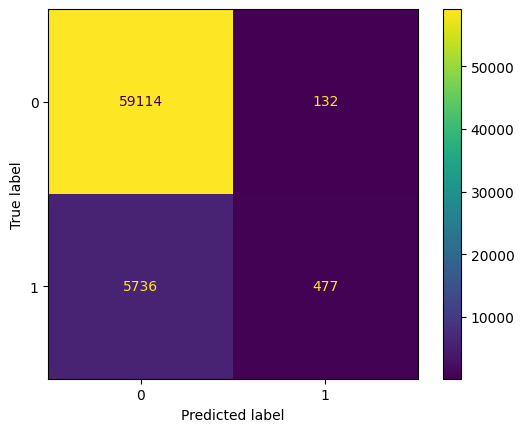

In [13]:
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix)
disp.plot()

### Methode 2: Univariate feature selection

 Le paramètre k fait référence au nombre de meilleures caractéristiques à sélectionner avec la méthode SelectKBest basée sur le test de chi2.

Plage de k : Le choix de la plage de k dépend de plusieurs facteurs :
Taille des données : La plage de k commence à 10 et va jusqu'au nombre total de colonnes (tot_col) dans le jeu de données X. Vous pouvez ajuster cette plage en fonction du nombre de caractéristiques disponibles dans vos données.
Évaluation des performances : Dans chaque itération, le code évalue les performances du modèle avec un nombre différent de caractéristiques (en fonction de k) et affiche des métriques comme la précision, le score F1, la précision, le rappel et le ROC AUC. Cela vous permet de choisir la valeur de k qui donne les meilleurs résultats.
Objectifs de la modélisation : Si vous recherchez un modèle plus simple et plus rapide, il peut être utile de tester des valeurs plus petites de k. Si vous souhaitez capturer plus de complexité dans les données, une valeur plus élevée peut être préférable.
Conseils supplémentaires pour choisir k :
Analyse des résultats : Après avoir exécuté le code, vous pouvez observer les valeurs de performance (précision, score F1, etc.) pour chaque k. Le but est de trouver un équilibre entre la réduction de la dimensionnalité et la performance du modèle.

Validation croisée : Vous pouvez également utiliser la validation croisée pour obtenir des évaluations plus robustes des performances pour chaque valeur de k et éviter un ajustement excessif.

En résumé, il n'y a pas de valeur fixe pour k, et le choix dépend de vos objectifs, des performances du modèle, et de la complexité des données.

In [14]:
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.metrics import roc_curve, auc



In [44]:
def XGB(X, y):
    # Division des données en ensembles d'entraînement et de validation
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Classifieur XGBoost
    clf = xgb.XGBClassifier()
    y_train = y_train.values.ravel()
    clf.fit(X_train, y_train)
    
    # Prédictions sur l'ensemble de validation
    y_pred = clf.predict(X_val)
    
    # Estimations des probabilités
    pred_probs = clf.predict_proba(X_val)
    
    # Évaluation des performances du modèle
    accuracy = metrics.accuracy_score(y_val, y_pred)  # Précision
    f1_score = metrics.f1_score(y_val, y_pred)        # Score F1
    precision = metrics.precision_score(y_val, y_pred)  # Précision (positifs correctement prévus)
    recall = metrics.recall_score(y_val, y_pred)      # Rappel (sensibilité)
    cf_matrix = metrics.confusion_matrix(y_val, y_pred)  # Matrice de confusion
    
    # Calcul du ROC AUC
    probs_isgoal = pred_probs[:, 1]
    roc_auc = metrics.roc_auc_score(y_val, probs_isgoal)
    
    return pred_probs, accuracy, f1_score, precision, recall, roc_auc, cf_matrix

In [1]:
import pandas as pd
data = pd.read_csv('Q4_train.csv', index_col=0)

# Classification binaire utilisant isGoal comme cible
X = data[data.columns.tolist()[:-1]]
y = data['isGoal']  

# Convertir y en tableau NumPy unidimensionnel
#y = y.ravel()

In [3]:
import numpy as np
col_list = X.columns.to_list()
#print(col_list)
feature_names = np.array(X.columns.to_list())
print(feature_names)

['period' 'shotType' 'coordinateX' 'coordinateY' 'emptynet' 'lastEvent'
 'lastCoordinateX' 'lastCoordinateY' 'lastDistance' 'timeLastEvent'
 'speed' 'rebound' 'distance' 'angle' 'gameSeconds' 'chang_angle'
 'non_gardiens_amicaux' 'non_gardiens_adverses']


In [46]:
#Feature Selection: Univariate Feature Selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import chi2

min_max_scaler = MinMaxScaler()

tot_col = len(X.columns)


X = X.copy()
#for col in X:
    #X[[col]] = min_max_scaler.fit_transform(X[[col]])
X[col_list] = min_max_scaler.fit_transform(X[col_list])

#Findking the best k values
for k_value in range(10, tot_col):
    X_new = SelectKBest(chi2, k=k_value).fit_transform(X, y)
    pred_probs, accuracy,f1_score, precision, recall, roc_auc, cf_matrix = XGB(X_new, y)
    print(f' k: {k_value} accuracy: {accuracy: 6.4}, f1_score: {f1_score: 6.4}, precision: {precision :6.4},\
    recall: {recall: 6.4}, roc_auc: {roc_auc: 6.4}')

 k: 10 accuracy:  0.9096, f1_score:  0.1093, precision: 0.8422,    recall:  0.05843, roc_auc:  0.7576
 k: 11 accuracy:  0.9098, f1_score:  0.1119, precision: 0.8571,    recall:  0.05987, roc_auc:  0.7666
 k: 12 accuracy:   0.91, f1_score:  0.1261, precision: 0.8019,    recall:  0.0684, roc_auc:  0.7677
 k: 13 accuracy:  0.9101, f1_score:  0.1236, precision: 0.8234,    recall:  0.0668, roc_auc:  0.7656
 k: 14 accuracy:  0.9101, f1_score:  0.1246, precision: 0.8216,    recall:  0.06744, roc_auc:  0.7769
 k: 15 accuracy:  0.9106, f1_score:  0.1481, precision: 0.7724,    recall:  0.08192, roc_auc:  0.7868
 k: 16 accuracy:  0.9104, f1_score:  0.1404, precision: 0.7827,    recall:  0.0771, roc_auc:  0.7857
 k: 17 accuracy:  0.9105, f1_score:  0.1466, precision: 0.7738,    recall:  0.08096, roc_auc:  0.787


In [47]:
#Selected k=15 based on f1_score and roc_auc
k = 15
selector = SelectKBest(score_func=chi2, k=k)
fit = selector.fit(X, y)
features = fit.transform(X)

selected_features = (feature_names[fit.scores_.argsort()[::-1][:k]]).tolist()
print(f' Selected Features')
print(selected_features)

X_new = X[selected_features]
print('Shape of new X', X_new.shape)

features_dropped = set(col_list).difference(selected_features)
print('features_dropped: ', features_dropped)

pred_probs, accuracy,f1_score, precision, recall, roc_auc, cf_matrix = XGB(X_new, y)
print(f' accuracy: {accuracy}')
print(f' f1_score: {f1_score}')
print(f' precision: {precision}')
print(f' recall: {recall}')
print(f' roc_auc: {roc_auc}')
print(f' Confusion Matrix')
print(cf_matrix)

 Selected Features
['emptynet', 'rebound', 'distance', 'speed', 'period', 'gameSeconds', 'lastEvent', 'chang_angle', 'non_gardiens_adverses', 'non_gardiens_amicaux', 'shotType', 'lastDistance', 'lastCoordinateY', 'coordinateY', 'timeLastEvent']
Shape of new X (327295, 15)
features_dropped:  {'angle', 'lastCoordinateX', 'coordinateX'}
 accuracy: 0.9104630379321408
 f1_score: 0.147242834279063
 precision: 0.7666666666666667
 recall: 0.08144213745372605
 roc_auc: 0.7862032847256624
 Confusion Matrix
[[59092   154]
 [ 5707   506]]


Sans validation croisée

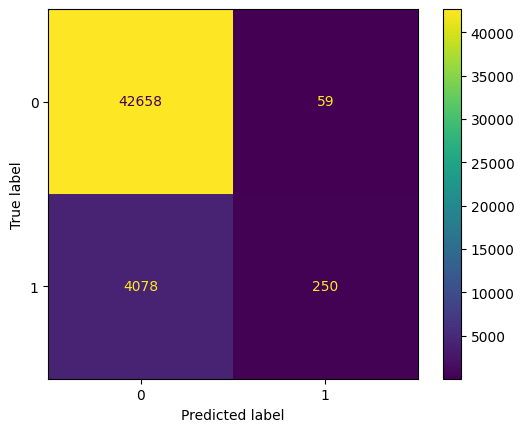

In [27]:
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix)
disp.plot()

Avec validation croisée

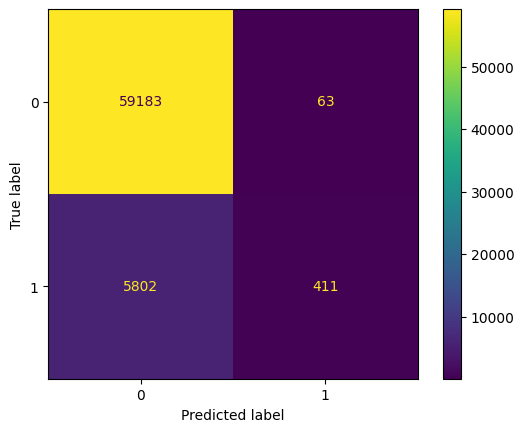

In [26]:
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix_val)
disp.plot()

Methode 3: Variance threshold

In [29]:
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.metrics import roc_curve, auc


In [48]:
def XGB(X,y):
    #Train and valid split
    X_train,X_val,y_train,y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # XGB Classifier
    clf = xgb.XGBClassifier()
    y_train = y_train.values.ravel()
    clf.fit(X_train, y_train)
    
    # Predict on validation set
    y_pred = clf.predict(X_val)
    
    #Probability estimates
    pred_probs = clf.predict_proba(X_val)
    
    
    #Model Evaultion Metrics
    accuracy = metrics.accuracy_score(y_val, y_pred)
    f1_score = metrics.f1_score(y_val, y_pred)
    precision = metrics.precision_score(y_val, y_pred)
    recall = metrics.recall_score(y_val, y_pred)
    cf_matrix = metrics.confusion_matrix(y_val,y_pred)
    
    probs_isgoal = pred_probs[:,1]
    roc_auc = metrics.roc_auc_score(y_val,probs_isgoal)
    

        
    return pred_probs, accuracy,f1_score, precision, recall, roc_auc, cf_matrix

Variance threshold

In [ ]:
# Read in data and assign X and y
data = pd.read_csv('../../data/train.csv', index_col=0)
X = data[data.columns.tolist()[:-1]]
y = data[['isGoal']]
X

In [49]:
import pandas as pd
data = pd.read_csv('Q4_train.csv', index_col=0)


# Classification binaire utilisant isGoal comme cible
X = data[data.columns.tolist()[:-1]]
y = data['isGoal']  


# Convertir y en tableau NumPy unidimensionnel
#y = y.values.ravel()

In [50]:
#Feature Selection: Low varience
from sklearn.feature_selection import VarianceThreshold

var_thres=VarianceThreshold(threshold=0.25)
var_thres.fit_transform(X)

#True: High Variance False: Low Variance
new_cols = var_thres.get_support() 
print(new_cols) 

#Low variance columns
concol = [column for column in X.columns if column not in X.columns[var_thres.get_support()]]

print("Features Dropped: ", concol)

#Dropping Low Variance Columns (75% or more similar) 
X = X.iloc[:,new_cols]
print('total columns after feature selection:', len(X.columns))
X.shape

[ True  True  True  True False  True  True  True  True  True  True False
  True  True  True  True False  True]
Features Dropped:  ['emptynet', 'rebound', 'non_gardiens_amicaux']
total columns after feature selection: 15


(327295, 15)

#XGB training on X_new with reduced feature space.Removed two features: 'emptyNet', 'rebound'
pred_probs, accuracy,f1_score, precision, recall, roc_auc, cf_matrix = XGB(X, y)
print(f' accuracy: {accuracy}')
print(f' f1_score: {f1_score}')
print(f' precision: {precision}')
print(f' recall: {recall}')
print(f' roc_auc: {roc_auc}')
print(cf_matrix)

In [51]:
#XGB training on X_new with reduced feature space.Removed two features: 'emptyNet', 'rebound'
pred_probs, accuracy,f1_score, precision, recall, roc_auc, cf_matrix = XGB(X, y)
print(f' accuracy: {accuracy}')
print(f' f1_score: {f1_score}')
print(f' precision: {precision}')
print(f' recall: {recall}')
print(f' roc_auc: {roc_auc}')
print(cf_matrix)

 accuracy: 0.910050566003147
 f1_score: 0.1394329143525285
 precision: 0.7583465818759937
 recall: 0.07677450507001449
 roc_auc: 0.7843878789813069
[[59094   152]
 [ 5736   477]]


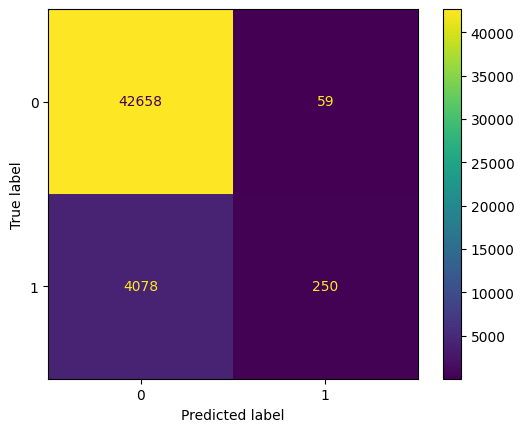

In [34]:
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix)
disp.plot()

 #### Methode 4: Feature Selection: Recursive feature elimination

In [27]:
import numpy as np
import pandas as pd
import xgboost as xgb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.metrics import roc_curve, auc
import joblib

In [4]:
def XGB(X,y):
    #Train and valid split
    X_train,X_val,y_train,y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # XGB Classifier
    clf = xgb.XGBClassifier()
    #y_train = y_train.values.ravel()
    clf.fit(X_train, y_train)
    
    # Predict on validation set
    y_pred = clf.predict(X_val)
    
    #Probability estimates
    pred_probs = clf.predict_proba(X_val)
    
    
    #Model Evaultion Metrics
    accuracy = metrics.accuracy_score(y_val, y_pred)
    f1_score = metrics.f1_score(y_val, y_pred)
    precision = metrics.precision_score(y_val, y_pred)
    recall = metrics.recall_score(y_val, y_pred)
    cf_matrix = metrics.confusion_matrix(y_val,y_pred)
    
    probs_isgoal = pred_probs[:,1]
    roc_auc = metrics.roc_auc_score(y_val,probs_isgoal)
    
        
    return pred_probs, accuracy,f1_score, precision, recall, roc_auc, cf_matrix

In [61]:
import pandas as pd
data = pd.read_csv('Q4_train.csv', index_col=0)

# Classification binaire utilisant isGoal comme cible
X = data[data.columns.tolist()[:-1]]
y = data['isGoal']  

# Convertir y en tableau NumPy unidimensionnel
y = y.values.ravel()

In [62]:
col_list = X.columns.to_list()
#print(col_list)
feature_names = np.array(X.columns.to_list())
print(feature_names)

['period' 'shotType' 'coordinateX' 'coordinateY' 'emptynet' 'lastEvent'
 'lastCoordinateX' 'lastCoordinateY' 'lastDistance' 'timeLastEvent'
 'speed' 'rebound' 'distance' 'angle' 'gameSeconds' 'chang_angle'
 'non_gardiens_amicaux' 'non_gardiens_adverses']


In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# Copie des données pour éviter les modifications sur l'original
X = X.copy()
tot_col = len(X.columns)

# Normalisation des données
min_max_scaler = MinMaxScaler()
X[col_list] = min_max_scaler.fit_transform(X[col_list])

# Initialisation du modèle
model = xgb.XGBClassifier()

# Sélection récursive des caractéristiques avec 15 caractéristiques à conserver
rfe = RFE(model, n_features_to_select=15)
fit = rfe.fit(X, y)

# Affichage du nombre de caractéristiques sélectionnées
print("Nombre de caractéristiques sélectionnées : ", fit.n_features_)

# Noms des caractéristiques sélectionnées
selected_features = feature_names[fit.support_]
print('Noms des caractéristiques sélectionnées : ', selected_features)

# Caractéristiques non sélectionnées
features_dropped = set(col_list).difference(selected_features)
print('Caractéristiques supprimées : ', features_dropped)

Nombre de caractéristiques sélectionnées :  15
Noms des caractéristiques sélectionnées :  ['shotType' 'coordinateX' 'coordinateY' 'emptynet' 'lastEvent'
 'lastCoordinateY' 'lastDistance' 'timeLastEvent' 'speed' 'rebound'
 'distance' 'angle' 'chang_angle' 'non_gardiens_amicaux'
 'non_gardiens_adverses']
Caractéristiques supprimées :  {'period', 'lastCoordinateX', 'gameSeconds'}


In [31]:
X_new = X[selected_features]
print('Shape of new X', X_new.shape)

Shape of new X (327295, 15)


In [42]:
pred_probs, accuracy,f1_score, precision, recall, roc_auc, cf_matrix = XGB(X_new, y)
print(f' accuracy: {accuracy}')
print(f' f1_score: {f1_score}')
print(f' precision: {precision}')
print(f' recall: {recall}')
print(f' roc_auc: {roc_auc}')
print(cf_matrix)

 accuracy: 0.9118928685301307
 f1_score: 0.11032410388495385
 precision: 0.7764350453172205
 recall: 0.05938077634011091
 roc_auc: 0.7607646304092138
[[42643    74]
 [ 4071   257]]


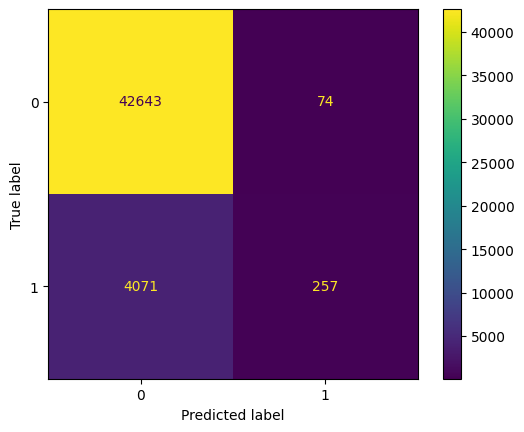

In [43]:
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix)
disp.plot()

Avec la validation croisée

In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
import xgboost as xgb
import numpy as np
import pandas as pd
import xgboost as xgb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.metrics import roc_curve, auc
import joblib

# Copie des données pour éviter les modifications sur l'original
X = X.copy()
tot_col = len(X.columns)

# Normalisation des données
min_max_scaler = MinMaxScaler()
X[col_list] = min_max_scaler.fit_transform(X[col_list])

# Initialisation du modèle XGBoost
model = xgb.XGBClassifier()

# Tester différents nombres de caractéristiques à conserver (de 10 à tot_col)
for n_features in range(10, tot_col + 1):  # Tester de 10 à tot_col
    # Sélection récursive des caractéristiques avec un nombre spécifique de caractéristiques à conserver
    rfe = RFE(model, n_features_to_select=n_features)
    fit = rfe.fit(X, y)
    
    # Affichage du nombre de caractéristiques sélectionnées
    print(f"Nombre de caractéristiques sélectionnées pour n={n_features} : ", fit.n_features_)
    
    # Noms des caractéristiques sélectionnées
    selected_features = X.columns[fit.support_]
    print(f'Caractéristiques sélectionnées pour n={n_features} : ', selected_features)

    # Caractéristiques non sélectionnées
    features_dropped = set(col_list).difference(selected_features)
    print(f'Caractéristiques supprimées pour n={n_features} : ', features_dropped)
    
    # Transformer les données en utilisant uniquement les caractéristiques sélectionnées
    features_selected = fit.transform(X)
    print('Dimensions des caractéristiques sélectionnées : ', features_selected.shape)
    
    # Entraîner le modèle XGBoost avec les caractéristiques sélectionnées
    pred_probs, accuracy, f1_score, precision, recall, roc_auc, cf_matrix = XGB(features_selected, y)
    
    print(f'n={n_features}, précision : {accuracy:6.4}, score F1 : {f1_score:6.4}, '
          f'précision : {precision:6.4}, rappel : {recall:6.4}, roc_auc : {roc_auc:6.4}')

Nombre de caractéristiques sélectionnées pour n=10 :  10
Caractéristiques sélectionnées pour n=10 :  Index(['shotType', 'coordinateY', 'emptynet', 'lastEvent', 'timeLastEvent',
       'speed', 'distance', 'angle', 'non_gardiens_amicaux',
       'non_gardiens_adverses'],
      dtype='object')
Caractéristiques supprimées pour n=10 :  {'period', 'lastCoordinateX', 'lastDistance', 'coordinateX', 'chang_angle', 'rebound', 'gameSeconds', 'lastCoordinateY'}
Dimensions des caractéristiques sélectionnées :  (327295, 10)
n=10, précision : 0.9099, score F1 : 0.1306, précision : 0.7786, rappel : 0.0713, roc_auc : 0.7886
Nombre de caractéristiques sélectionnées pour n=11 :  11
Caractéristiques sélectionnées pour n=11 :  Index(['shotType', 'coordinateY', 'emptynet', 'lastEvent', 'timeLastEvent',
       'speed', 'distance', 'angle', 'chang_angle', 'non_gardiens_amicaux',
       'non_gardiens_adverses'],
      dtype='object')
Caractéristiques supprimées pour n=11 :  {'period', 'lastCoordinateX', 'last

Cross-validation

In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_selection import RFE
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import numpy as np

# Copie des données pour éviter les modifications sur l'original
X = X.copy()
tot_col = len(X.columns)

# Normalisation des données
min_max_scaler = MinMaxScaler()
X[col_list] = min_max_scaler.fit_transform(X[col_list])

# Initialisation du modèle XGBoost
model = xgb.XGBClassifier()

# Sélection récursive des caractéristiques avec 10 caractéristiques à conserver
rfe = RFE(model, n_features_to_select=10)
fit = rfe.fit(X, y)

# Noms des caractéristiques sélectionnées
selected_features = X.columns[fit.support_]
print(f'Caractéristiques sélectionnées pour n_features=10 : ', selected_features)

# Transformer les données en utilisant uniquement les caractéristiques sélectionnées
X_selected = fit.transform(X)
print('Dimensions des caractéristiques sélectionnées : ', X_selected.shape)

# Séparation des données d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X_selected, y, test_size=0.2, random_state=42)


# Paramètres pour la recherche aléatoire sur les hyperparamètres
params = {
    'n_estimators': [100, 200],
    'max_depth': [6, 10],
    'learning_rate': [0.05, 0.1],
    'booster': ['gbtree'],
    'gamma': [0, 0.5, 1],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0.5, 1, 5],
}

# Recherche aléatoire sur les hyperparamètres avec validation croisée
recherche = RandomizedSearchCV(
    estimator=model,
    param_distributions=params,
    scoring='roc_auc',
    refit=True,
    cv=5,
    verbose=10,
    n_iter=100,
    # n_jobs=-1  # Utilise tous les cœurs disponibles pour l'entraînement
)

# Appliquer la recherche sur les données d'entraînement
recherche.fit(X_train, y_train)

# Meilleurs paramètres et score
meilleurs_params = recherche.best_params_
meilleur_score_grille = recherche.best_score_
print(f'Meilleur score (validation croisée) pour n_features=10 :', meilleur_score_grille)
print(f'Meilleurs paramètres pour n_features=10 :', meilleurs_params)

# Prédictions sur l'ensemble de validation
y_pred = recherche.predict(X_val)
pred_probs = recherche.predict_proba(X_val)

# Calculer les métriques d'évaluation du modèle
accuracy_val = metrics.accuracy_score(y_val, y_pred)  # Précision
f1_score_val = metrics.f1_score(y_val, y_pred)       # Score F1
precision_val = metrics.precision_score(y_val, y_pred)  # Précision (positifs prédits corrects)
recall_val = metrics.recall_score(y_val, y_pred)        # Rappel (sensibilité)
cf_matrix_val = metrics.confusion_matrix(y_val, y_pred)  # Matrice de confusion

# Calculer l'AUC ROC
probs_isgoal_val = pred_probs[:, 1]  # Probabilités pour la classe positive
roc_auc_val = metrics.roc_auc_score(y_val, probs_isgoal_val)

# Affichage des résultats de la validation
print(f'n_features=10, précision : {accuracy_val:6.4}, score F1 : {f1_score_val:6.4}, '
      f'précision : {precision_val:6.4}, rappel : {recall_val:6.4}, roc_auc : {roc_auc_val:6.4}')
print('Matrice de confusion :\n', cf_matrix_val)

Caractéristiques sélectionnées pour n_features=10 :  Index(['shotType', 'coordinateY', 'emptynet', 'lastEvent', 'timeLastEvent',
       'speed', 'distance', 'angle', 'non_gardiens_amicaux',
       'non_gardiens_adverses'],
      dtype='object')
Dimensions des caractéristiques sélectionnées :  (327295, 10)
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5; 1/100] START booster=gbtree, gamma=0, learning_rate=0.1, max_depth=10, n_estimators=200, reg_alpha=0.5, reg_lambda=0.5
[CV 1/5; 1/100] END booster=gbtree, gamma=0, learning_rate=0.1, max_depth=10, n_estimators=200, reg_alpha=0.5, reg_lambda=0.5;, score=0.775 total time=   3.1s
[CV 2/5; 1/100] START booster=gbtree, gamma=0, learning_rate=0.1, max_depth=10, n_estimators=200, reg_alpha=0.5, reg_lambda=0.5
[CV 2/5; 1/100] END booster=gbtree, gamma=0, learning_rate=0.1, max_depth=10, n_estimators=200, reg_alpha=0.5, reg_lambda=0.5;, score=0.779 total time=   3.0s
[CV 3/5; 1/100] START booster=gbtree, gamma=0, learning_

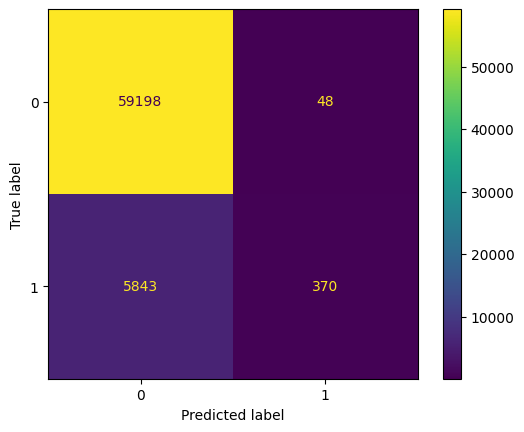

In [38]:
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix_val)
disp.plot()

Meilleur modele sur wandB

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: khalida-g (thalia-cantero-udem). Use `wandb login --relogin` to force relogin


Index(['period', 'shotType', 'coordinateX', 'coordinateY', 'emptynet',
       'lastEvent', 'lastCoordinateX', 'lastCoordinateY', 'lastDistance',
       'timeLastEvent', 'speed', 'rebound', 'distance', 'angle', 'gameSeconds',
       'chang_angle', 'non_gardiens_amicaux', 'non_gardiens_adverses',
       'isGoal'],
      dtype='object')


C:\Users\user\AppData\Local\Temp\ipykernel_13980\3586902555.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col_list] = min_max_scaler.fit_transform(X[col_list])


Caractéristiques sélectionnées pour n_features=10 :  Index(['shotType', 'coordinateY', 'emptynet', 'lastEvent', 'timeLastEvent',
       'speed', 'distance', 'angle', 'non_gardiens_amicaux',
       'non_gardiens_adverses'],
      dtype='object')
Dimensions des caractéristiques sélectionnées :  (327295, 10)
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5; 1/100] START booster=gbtree, gamma=0, learning_rate=0.05, max_depth=10, n_estimators=200, reg_alpha=0.5, reg_lambda=5
[CV 1/5; 1/100] END booster=gbtree, gamma=0, learning_rate=0.05, max_depth=10, n_estimators=200, reg_alpha=0.5, reg_lambda=5;, score=0.783 total time=   2.7s
[CV 2/5; 1/100] START booster=gbtree, gamma=0, learning_rate=0.05, max_depth=10, n_estimators=200, reg_alpha=0.5, reg_lambda=5
[CV 2/5; 1/100] END booster=gbtree, gamma=0, learning_rate=0.05, max_depth=10, n_estimators=200, reg_alpha=0.5, reg_lambda=5;, score=0.788 total time=   2.7s
[CV 3/5; 1/100] START booster=gbtree, gamma=0, learning_rate

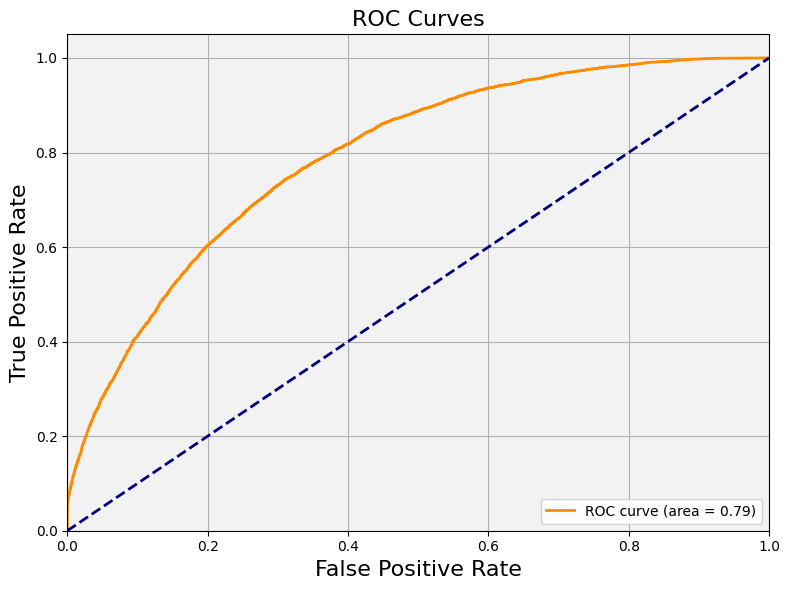

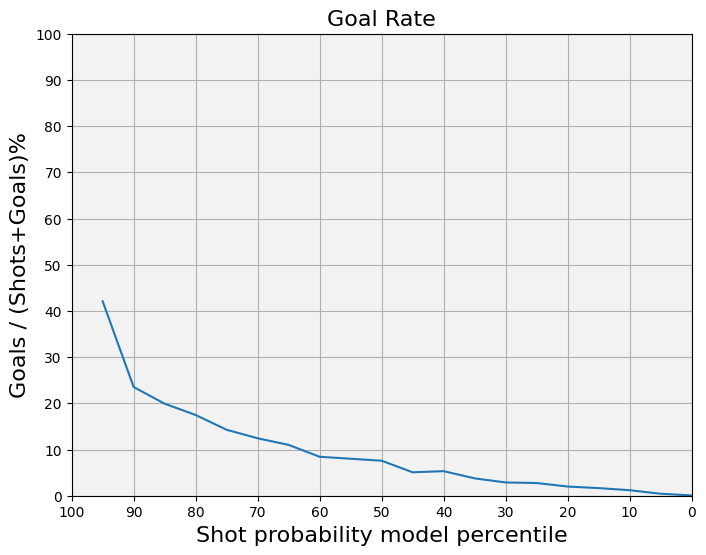

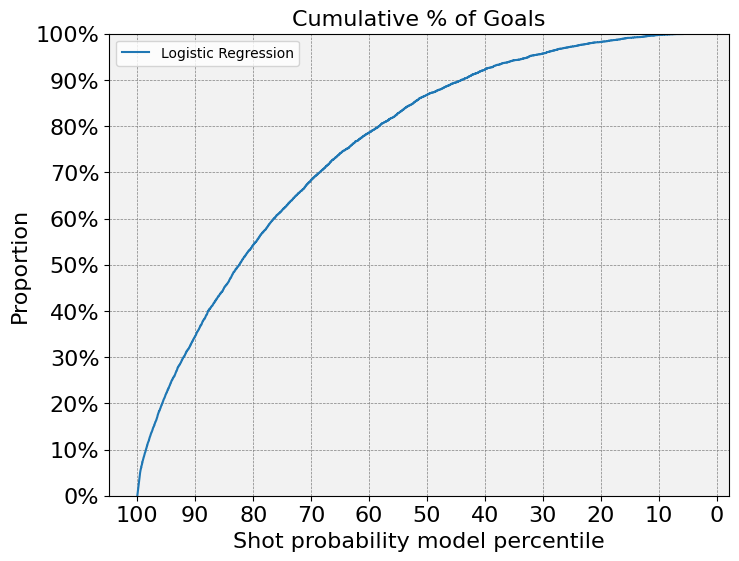

<Figure size 800x600 with 0 Axes>

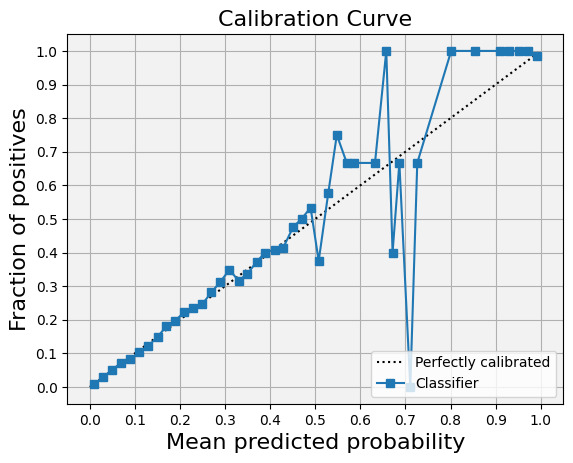

0.7878031379956079 0.9100047357888144 0.11159704418639722 0.8851674641148325 0.05955255110252696 0.7915728601420875
[[59198    48]
 [ 5843   370]]


In [9]:
import wandb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_selection import RFE
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import pickle
from plot_metrics import *  # Assurez-vous d'avoir des fonctions pour les plots comme plot_ROC, plot_goal_rates, etc.

# Connexion à WandB (authentification via clé API)
wandb.login()

# Lecture des données
data = pd.read_csv('Q4_train.csv', index_col=0)
print(data.columns)
X = data[data.columns.tolist()[:-1]]  # Toutes les colonnes sauf la dernière
y = data[['isGoal']]  # La colonne cible

# Fonction pour entraîner, enregistrer et journaliser le modèle
def XGB_avec_wandb(X, y):
    # Initialiser une expérience WandB
    run = wandb.init(
        project="Milestone2_Q5",  # Nom du projet
        entity="thalia-cantero-udem",  # Organisation ou utilisateur
        name="xgb_Sel_chars_rfe_best_model_params",  # Nom de l'expérience
        tags=["rfe_selec_char", "XGB", "grid_best_params"],  # Tags pour organiser l'expérience
    )

    # Normalisation des données
    min_max_scaler = MinMaxScaler()
    col_list = X.columns.to_list()
    X[col_list] = min_max_scaler.fit_transform(X[col_list])

    # Sélection récursive des caractéristiques avec 10 caractéristiques à conserver
    model = xgb.XGBClassifier()
    rfe = RFE(model, n_features_to_select=10)
    fit = rfe.fit(X, y)

    # Noms des caractéristiques sélectionnées
    selected_features = X.columns[fit.support_]
    print(f'Caractéristiques sélectionnées pour n_features=10 : ', selected_features)

    # Transformer les données en utilisant uniquement les caractéristiques sélectionnées
    X_selected = fit.transform(X)
    print('Dimensions des caractéristiques sélectionnées : ', X_selected.shape)

    # Séparation des données d'entraînement et de validation
    X_train, X_val, y_train, y_val = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    y_train = y_train.values.ravel()

    # Paramètres pour la recherche aléatoire sur les hyperparamètres
    params = {
        'n_estimators': [100, 200],
        'max_depth': [6, 10],
        'learning_rate': [0.05, 0.1],
        'booster': ['gbtree'],
        'gamma': [0, 0.5, 1],
        'reg_alpha': [0, 0.5, 1],
        'reg_lambda': [0.5, 1, 5],
    }

    # Recherche aléatoire sur les hyperparamètres
    recherche = RandomizedSearchCV(
        estimator=model,
        param_distributions=params,
        scoring='roc_auc',
        refit=True,
        cv=5,
        verbose=10,
        n_iter=100,
    )

    recherche.fit(X_train, y_train)

    # Meilleurs paramètres et score
    meilleurs_params = recherche.best_params_
    meilleur_score_grille = recherche.best_score_
    print(f'Meilleur score (validation croisée) pour n_features=10 :', meilleur_score_grille)
    print(f'Meilleurs paramètres pour n_features=10 :', meilleurs_params)

    # Prédictions sur l'ensemble de validation
    y_pred = recherche.predict(X_val)
    pred_probs = recherche.predict_proba(X_val)
    probs_isgoal = pred_probs[:, 1]

    # Métriques d'évaluation du modèle
    accuracy_val = metrics.accuracy_score(y_val, y_pred)
    f1_score_val = metrics.f1_score(y_val, y_pred)
    precision_val = metrics.precision_score(y_val, y_pred)
    recall_val = metrics.recall_score(y_val, y_pred)
    cf_matrix_val = metrics.confusion_matrix(y_val, y_pred)
    roc_auc_val = metrics.roc_auc_score(y_val, probs_isgoal)

    # Enregistrement du modèle localement sous le nom spécifié
    nom_fichier_modele = "xgb__rfe_selec_char_grid_search1_model.pkl"
    pickle.dump(recherche, open(nom_fichier_modele, "wb"))

    # Enregistrement du modèle comme artefact dans WandB
    artifact = wandb.Artifact(
        name="xgb_rfe_selec_char_grid_search1_model",
        type="model",
        description="XGBoost avec recherche de grille et sélection des caractéristiques par RFE",
        metadata={
            "Meilleur score (grille)": meilleur_score_grille,
            "Exactitude": accuracy_val,
            "Score F1": f1_score_val,
            "Précision": precision_val,
            "Rappel": recall_val,
            "AUC ROC": roc_auc_val,
        },
    )
    artifact.add_file(nom_fichier_modele)
    run.log_artifact(artifact)

    # Courbe ROC
    plot_ROC(y_val, pred_probs)
    wandb.log({"Courbe ROC": wandb.Image("roc_curve.png")})

    # Autres graphiques
    df_percentile = calc_percentile(pred_probs, y_val)
    goal_rate_df = goal_rate(df_percentile)
    plot_goal_rates(goal_rate_df)
    wandb.log({"Taux de but": wandb.Image("goal_rate_plot.png")})

    plot_cumulative_goal_rates(df_percentile)
    wandb.log({"Taux cumulé de but": wandb.Image("cumulative_goal_rate.png")})

    plot_calibration_curve_prediction(y_val, pred_probs)
    wandb.log({"Courbe de calibration": wandb.Image("calibration_curve.png")})

    # Fin de l'expérience
    run.finish()

    # Retour des résultats
    return pred_probs, accuracy_val, f1_score_val, precision_val, recall_val, roc_auc_val, cf_matrix_val, meilleur_score_grille

# Appeler la fonction pour l'exécution
if __name__ == "__main__":
    pred_probs, accuracy_val, f1_score_val, precision_val, recall_val, roc_auc_val, cf_matrix_val, meilleur_score_grille = XGB_avec_wandb(X, y)
    print(meilleur_score_grille, accuracy_val, f1_score_val, precision_val, recall_val, roc_auc_val)
    print(cf_matrix_val)

In [10]:

print(f' accuracy: {accuracy_val}')
print(f' f1_score: {f1_score_val}')
print(f' precision: {precision_val}')
print(f' recall: {recall_val}')
print(f' roc_auc: {roc_auc_val}')
print('Confusion Matrix')
print(cf_matrix)


 accuracy: 0.9100047357888144
 f1_score: 0.11159704418639722
 precision: 0.8851674641148325
 recall: 0.05955255110252696
 roc_auc: 0.7915728601420875
Confusion Matrix
[[59091   155]
 [ 5711   502]]
